# Evaluation

The main objectives of this notebook are to:

- Enable proactive retention strategies to reduce customer turnover.
- Achieve a balance between recall (catching as many churners as possible) and precision (avoiding unnecessary interventions to minimise business costs).


- minimize lost customers → high recall
- target real churners only → high precision

## 1. Import libraries

In [1]:
# Imports 
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report, precision_recall_curve, average_precision_score, roc_auc_score, roc_curve

In [2]:
# Import os module
import os  

# Show current working directory
print(os.getcwd())

/Users/eseoseodion/Documents/Portfolio/Customer Churn Prediction/notebooks


In [3]:
# Set file path to the dataset
file_path = '../data/telco_customer_churn_eda.csv'

## 2. Load datasets and models

In [4]:
# Import joblib for loading saved models and data
import joblib

#  Load the scaler 
# scaler = joblib.load('../saved_data/scaler/scaler.pkl')  # (optional if needed later)

#  Load training and test datasets
X_train_tree = joblib.load('../saved_data/train_test_data/X_train_tree.pkl')
X_train_linear = joblib.load('../saved_data/train_test_data/X_train_linear.pkl')

X_test_tree = joblib.load('../saved_data/train_test_data/X_test_tree.pkl')
X_test_linear = joblib.load('../saved_data/train_test_data/X_test_linear.pkl')

y_train_tree = joblib.load('../saved_data/train_test_data/y_train_tree.pkl')
y_train_linear = joblib.load('../saved_data/train_test_data/y_train_linear.pkl')

y_test = joblib.load('../saved_data/train_test_data/y_test.pkl')

# Load trained models 
lr_classifier = joblib.load('../saved_models/LogisticRegression.pkl')
svc_classifier = joblib.load('../saved_models/SVC.pkl')
dt_classifier = joblib.load('../saved_models/DecisionTreeClassifier.pkl')
rf_classifier = joblib.load('../saved_models/RandomForestClassifier.pkl')
xgb_classifier = joblib.load('../saved_models/XGBClassifier.pkl')
lgb_classifier = joblib.load('../saved_models/LGBMClassifier.pkl')
cat_classifier = joblib.load('../saved_models/CatBoostClassifier.pkl')

# List of all loaded models
models = [lr_classifier, svc_classifier, dt_classifier, rf_classifier, xgb_classifier, lgb_classifier, cat_classifier]

In [76]:
X_train_tree.shape

(7228, 20)

In [77]:
tree_names = joblib.load('../saved_data/feature_names/tree_feature_names.pkl')

print(tree_names)

['SeniorCitizen', 'tenure', 'MonthlyCharges_log', 'TotalCharges_log', 'average_charges_per_month', 'contract_loyalty', 'contract_progress', 'ServiceCount', 'charge_tenure_ratio_log', 'security_bundle', 'is_long_contract', 'family_flag', 'Contract', 'gender', 'PaperlessBilling', 'InternetService_Fiber optic', 'OnlineSecurity_No', 'TechSupport_No', 'PaymentMethod_Electronic check', 'billing_flag_partial_month']


In [78]:
linear_names = joblib.load('../saved_data/feature_names/linear_feature_names.pkl')

print(linear_names)

['SeniorCitizen', 'charge_tenure_ratio_log', 'high_engagement_loyalty', 'high_risk_contract', 'entertainment_bundle', 'Contract', 'tenure_bin', 'Dependents', 'PhoneService', 'MultipleLines_categorised', 'OnlineSecurity_categorised', 'TechSupport_categorised', 'PaperlessBilling', 'InternetService_Fiber optic', 'InternetService_No', 'PaymentMethod_Electronic check', 'billing_flag_discount', 'billing_flag_ok']


In [74]:
X_train_linear.shape

(7228, 18)

In [5]:
# Create a dictionary for both training label sets
y_train_sets = {'y_train_tree': y_train_tree, 'y_train_linear': y_train_linear}

# Loop through each label set
for name, y in y_train_sets.items():
    # Convert to DataFrame
    y_df = pd.DataFrame(y, columns=['Churn'])

    # Show value counts
    print(f"Value Count for {name}")
    print(y_df.value_counts())
    print("\n")

    # Show percentage distribution
    print(f"Percentages for {name}")
    print(y_df.value_counts(normalize=True) * 100)
    print("\n")


Value Count for y_train_tree
Churn
0        3614
1        3614
Name: count, dtype: int64


Percentages for y_train_tree
Churn
0        50.0
1        50.0
Name: proportion, dtype: float64


Value Count for y_train_linear
Churn
0        3614
1        3614
Name: count, dtype: int64


Percentages for y_train_linear
Churn
0        50.0
1        50.0
Name: proportion, dtype: float64




Classes are perfectly balanced. This isn't the cause of the overfitting

## 3. Stratified Cross-Validation (on Training Set)

In [6]:
# Import cross-validation function
from sklearn.model_selection import cross_validate, StratifiedKFold

# Group models into two families
models = {
    "linear models": [lr_classifier, svc_classifier],
    "tree models": [dt_classifier, rf_classifier, xgb_classifier, lgb_classifier, cat_classifier]
}

# Define metrics to evaluate
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

# Set up 5-fold stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []

# Loop through each model family and model
for family, model_list in models.items():
    for model in model_list:
        print(f"\nCross-Validation Scores for {model.__class__.__name__}")

        # Use the right dataset for each model type
        if family == "linear models":
            scores = cross_validate(model, X_train_linear, y_train_linear, cv=skf, scoring=scoring, n_jobs=-1)
        else:
            scores = cross_validate(model, X_train_tree, y_train_tree, cv=skf, scoring=scoring, n_jobs=-1)

        # Save average results
        results.append({
            'Model': model.__class__.__name__,
            'Accuracy': scores['test_accuracy'].mean(),
            'Precision': scores['test_precision'].mean(),
            'Recall': scores['test_recall'].mean(),
            'F1 Score': scores['test_f1'].mean(),
            'ROC AUC': scores['test_roc_auc'].mean(),
            'PR AUC': scores['test_pr_auc'].mean()
        })


Cross-Validation Scores for LogisticRegression

Cross-Validation Scores for SVC

Cross-Validation Scores for DecisionTreeClassifier

Cross-Validation Scores for RandomForestClassifier

Cross-Validation Scores for XGBClassifier

Cross-Validation Scores for LGBMClassifier
[LightGBM] [Info] Number of positive: 2891, number of negative: 2891[LightGBM] [Info] Number of positive: 2891, number of negative: 2892[LightGBM] [Info] Number of positive: 2891, number of negative: 2891


[LightGBM] [Info] Number of positive: 2892, number of negative: 2891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ov

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:27

[LightGBM] [Info] Number of positive: 2891, number of negative: 2891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4114
[LightGBM] [Info] Number of data points in the train set: 5782, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Cross-Validation Scores for CatBoostClassifier


##### **<u>Rationale</u>**

Stratified Cross-Validation was used to ensure that each fold in the training data preserved the same proportion of churn and non-churn customers as the original dataset.
This is important because the churn dataset is imbalanced, meaning one class (non-churners) occurs much more frequently than the other (churners).

Using stratification will help to:

- Maintain consistent class distribution across all folds.

- Prevent the model from being biased toward the majority class during training.

- Provide a more reliable and fair estimate of the model’s performance on unseen data.

By applying this only on the training set, it ensured that the model’s evaluation reflected real-world performance while keeping the test set untouched for final validation.

## 4. Using Metrics to Evaluate on the Training Set

### 4.1. Displaying results as a table

In [7]:
# Convert results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame with values rounded to 4 decimal places
display(results_df.round(4))

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC  \
0      LogisticRegression    0.7806     0.7661  0.8082    0.7864   0.8629   
1                     SVC    0.7763     0.7644  0.7991    0.7812   0.8611   
2  DecisionTreeClassifier    0.8182     0.8169  0.8204    0.8186   0.8187   
3  RandomForestClassifier    0.8705     0.8796  0.8586    0.8689   0.9440   
4           XGBClassifier    0.8599     0.8738  0.8412    0.8571   0.9389   
5          LGBMClassifier    0.8633     0.8763  0.8462    0.8609   0.9428   
6      CatBoostClassifier    0.8668     0.8797  0.8498    0.8644   0.9431   

   PR AUC  
0  0.8487  
1  0.8466  
2  0.7605  
3  0.9445  
4  0.9484  
5  0.9512  
6  0.9510

##### **<u>Metrics Used:</u>**

- Accuracy: To evaluate the proportion of correctly classified instances out of all instances.

- Precision: To determine out of all positive predictions, how many were actually correct.

- Recall: To determine out of all actual positives, how many were correctly identified.

- F1 Score: This is the harmonic mean of Precision and Recall – balances both.

- ROC AUC: To measure the model’s ability to distinguish between classes. Higher = better.

- PR AUC: To check the area under the Precision-Recall curve. it is important when handling imbalanced data.


From the results:

- The tree-based models (Random Forest, XGBoost, LightGBM, and CatBoost) outperformed the linear models (Logistic Regression and SVC) across most metrics.

- CatBoostClassifier achieved the highest overall performance, with strong precision, recall, and AUC values — suggesting it captures complex patterns in the data effectively.

- Random Forest also performed very well, showing robust balance across metrics.

- Linear models, while slightly lower in accuracy and AUC, still provided consistent and interpretable results.

These results suggest that ensemble tree-based models are better suited for this dataset, likely because they can handle nonlinear relationships and feature interactions more effectively.

---

##### **Justification for Metrics Used**

The main business goal is to minimize customer loss while targeting real churners accurately.
This directly influences the choice of metrics used to evaluate the models.

1. <u>Recall (Sensitivity):</u>
- Captures the proportion of actual churners correctly identified by the model.
- Business link: A high recall ensures minimized customer losses by catching as many potential churners as possible.
- Goal: Reduce false negatives (customers who churn but were not predicted to) by increasong Recall.

2. <u>Precision:</u>

- Measures how many of the customers predicted as churners actually churn.
- Business link: A high precision ensures that only true churners are targeted, avoiding unnecessary marketing or retention costs on loyal customers.
- Goal: Reduce false positives (non-churners wrongly identified as churners) by increasong Precision.

3. <u>F1 Score:</u>

- Provides a single metric that balances precision and recall.
- Business link: Since both catching churners and avoiding false alarms are important, F1 helps assess the trade-off between the two.

4. <u>ROC AUC (Receiver Operating Characteristic Area Under Curve):</u>

- Evaluates the model’s overall ability to distinguish between churners and non-churners, regardless of threshold.
- Business link: Useful for comparing models’ general performance before final threshold tuning.

5. <u>PR AUC (Precision-Recall Area Under Curve)</u>

- Focuses more on the positive (churn) class, which is often the minority in churn datasets.
- Business link: Helps evaluate performance specifically on churners, aligning closely with the goal of identifying true at-risk customers.


Because the goal is to minimize customer loss (→ high recall) and target only true churners (→ high precision), these metrics collectively ensure a balanced and meaningful evaluation of model performance.


## 5. Model Tuning (Hyperparameter Optimization)

### 5.1. Random Search

In [8]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from scipy.stats import uniform
from scipy.stats import randint

#### 5.1.1. Defining the Hyperparameter Spaces For Each Model

In [9]:
# Define hyperparameter space for the Logistic Regression Model 
lr_param_dist = {
    'C': loguniform(1e-4, 1e4),
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['saga'],
    'max_iter': [1000]
}

# Define hyperparameter space for the Support Vector Machine Model 
svc_param_dist = {
    "C": loguniform(1e-3, 1e3),             # Regularization parameter
    "kernel": ["linear", "rbf", "poly", "sigmoid"],  
    "degree": [2, 3, 4, 5],                 # Used only if kernel='poly'
    "gamma": ["scale", "auto", loguniform(1e-4, 1e1)],  # Kernel coefficient
    # "class_weight": [None, "balanced"],     # Handles imbalance
    "shrinking": [True, False]
}

# Define hyperparameter space for the Decision Tree Model 
dt_param_dist = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None, 'sqrt', 'log2']
}

# Define hyperparameter space for the Random Forest Model 
rf_param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

#  Define hyperparameter space for the XGBoost Model
xgb_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 15),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

#  Define hyperparameter space for the LGB Model 
lgb_param_dist = {
    'num_leaves': randint(20, 150),          # instead of np.arange
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),     # draws random floats in [0.01, 0.31)
    'n_estimators': randint(100, 1000),
    'min_child_samples': randint(10, 100),
    'subsample': uniform(0.5, 0.5),          # random values between 0.5–1.0
    'colsample_bytree': uniform(0.5, 0.5),   # random values between 0.5–1.0
    'reg_alpha': uniform(0, 1.0),
    'reg_lambda': uniform(0, 1.0)
}

#  Define hyperparameter space for the CatBoost Model 
cat_param_dist = {
    'iterations': randint(100, 500),
    'depth': randint(4, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': randint(1, 10)
}

##### **Hyperparameter Tuning Setup**

To improve the performance of each machine learning model, a hyperparameter search space was defined specifying the key parameters that most influence model behavior.
Instead of manually selecting these values, the RandomizedSearchCV class was used, which randomly samples combinations of hyperparameters within the specified ranges.
This approach is faster and more efficient than an exhaustive Grid Search, especially when working with multiple models and large search spaces.

Below is a summary of the hyperparameter distributions used for each model:


**1. Logistic Regression**

- `C`: Controls the strength of regularization (searched on a log scale from very small to very large values).
- `penalty`: Type of regularization (`l1`, `l2`, `elasticnet`, or none).
- `solver`: Chosen as `'saga'` because it supports all penalty types.
- `max_iter`: Set high enough to ensure model convergence. 

**2. Support Vector Classifier (SVC)**

- `C`: Regularization parameter controlling the trade-off between margin size and misclassification.
- `kernel`: Different kernel functions tested (`linear`, `rbf`, `poly`, `sigmoid`).
- `degree`: Only relevant for the polynomial kernel.
- `gamma`: Defines how far the influence of a single training example reaches.
- `shrinking`: Tested both True/False for solver efficiency.

**3. Decision Tree**

- `criterion`: Measures the quality of splits (`gini`, `entropy`, or `log_loss`).
- `max_depth`, `min_samples_split`, `min_samples_leaf`: Controls tree complexity to prevent overfitting.
- `max_features`: Determines the number of features considered at each split.

**4. Random Forest**

- `n_estimators`: Number of trees in the forest.
- `max_depth`: Maximum tree depth to control model variance.
- `min_samples_split` and `min_samples_leaf`: Prevents overfitting by controlling leaf sizes.
- `bootstrap`: Determines whether bootstrap samples are used when building trees.

**5. XGBoost**

- `n_estimators`: Number of boosting rounds.
- `max_depth`: Depth of each tree.
- `learning_rate`: Step size shrinkage used in updating weights.
- `subsample` and `colsample_bytree`: Fraction of samples and features used per tree to add randomness and reduce overfitting.

**6. LightGBM**

- `num_leaves` and `max_depth`: Control tree complexity.
- `learning_rate`: Balances the contribution of each boosting iteration.
- `n_estimators`: Number of boosting rounds.
- `min_child_samples`: Minimum number of samples per leaf.
- `subsample` and `colsample_bytree`: Introduce randomness and improve generalization.
- `reg_alpha` and `reg_lambda`: Apply L1 and L2 regularization to reduce overfitting.

**7. CatBoost**

- `iterations`: Number of boosting iterations.
- `depth`: Depth of each tree.
- `learning_rate`: Controls step size for weight updates.
- `l2_leaf_reg`: Regularization term to reduce overfitting.


---


##### **Justification**

A Random Search was chosen over a Grid Search because:

- It samples randomly across the entire parameter space, often finding strong combinations faster, hence saving time
- It’s computationally cheaper since it doesn’t evaluate every possible combination.
- It searches broader ranges of hyperparameters efficiently.

#### 5.1.2. Conducting the Random Search for All Models

In [10]:
# List of models in the same order as param_dists 
mods = [
    lr_classifier,
    svc_classifier,
    dt_classifier,
    rf_classifier,
    xgb_classifier,
    lgb_classifier,
    cat_classifier
]

#  Corresponding parameter distributions for each model 
param_dists = [
    lr_param_dist,
    svc_param_dist,
    dt_param_dist, 
    rf_param_dist,
    xgb_param_dist,
    lgb_param_dist,
    cat_param_dist
]

#  Short names for each model 
mod_names = ['lr', 'svc', 'dt', 'rf', 'xgb', 'lgb', 'cat']

#  Dictionaries to store results and best models
random_searches = {}
best_models = {}

#  Loop through models, parameters, and names together 
for model, params, name in zip(mods, param_dists, mod_names):
    print(f"Running RandomizedSearchCV for {name.upper()}...")

    # Set up RandomizedSearchCV with F1 as the scoring metric
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=15,
        cv=skf,
        scoring='f1',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Use the right dataset type for each model
    if name in ['lr', 'svc']:
        search.fit(X_train_linear, y_train_linear)
    else:
        search.fit(X_train_tree, y_train_tree)

    # Store the search object and best model
    random_searches[f"{name}_search"] = search
    best_models[f"best_{name}_model"] = search.best_estimator_

    # Print the best F1 score found
    print(f"Best F1 Score for {name.upper()}: {search.best_score_:.4f}")


Running RandomizedSearchCV for LR...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END C=0.0029341230215132346, max_iter=1000, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.0029341230215132346, max_iter=1000, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.0029341230215132346, max_iter=1000, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.0029341230215132346, max_iter=1000, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.0029341230215132346, max_iter=1000, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.09915644566638401, max_iter=1000, penalty=l1, solver=saga; total time=   0.1s
[CV] END C=0.09915644566638401, max_iter=1000, penalty=l1, solver=saga; total time=   0.1s
[CV] END C=6.155564318973028, max_iter=1000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.09915644566638401, max_iter=1000, penalty=l1, solver=saga; total time=   0.1s
[CV] END C=6.155564318973028, max_iter=1000, penalty=elas

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
50 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/base

[CV] END C=98.77700294007911, degree=3, gamma=auto, kernel=sigmoid, shrinking=False; total time=   2.9s
[CV] END C=3.907967156822881, degree=4, gamma=auto, kernel=poly, shrinking=True; total time=   3.4s
[CV] END C=3.907967156822881, degree=4, gamma=auto, kernel=poly, shrinking=True; total time=   3.5s
[CV] END C=3.907967156822881, degree=4, gamma=auto, kernel=poly, shrinking=True; total time=   3.5s
[CV] END C=3.907967156822881, degree=4, gamma=auto, kernel=poly, shrinking=True; total time=   3.5s
[CV] END C=3.907967156822881, degree=4, gamma=auto, kernel=poly, shrinking=True; total time=   3.6s
[CV] END C=98.77700294007911, degree=3, gamma=auto, kernel=sigmoid, shrinking=False; total time=   1.7s
[CV] END C=0.002231010801867922, degree=5, gamma=scale, kernel=sigmoid, shrinking=False; total time=   5.2s
[CV] END C=0.002231010801867922, degree=5, gamma=scale, kernel=sigmoid, shrinking=False; total time=   5.3s
[CV] END C=0.002231010801867922, degree=5, gamma=scale, kernel=sigmoid, shri

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/base

Best F1 Score for SVC: 0.8317
Running RandomizedSearchCV for DT...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END criterion=log_loss, max_depth=17, max_features=log2, min_samples_leaf=8, min_samples_split=8; total time=   0.2s
[CV] END criterion=log_loss, max_depth=4, max_features=sqrt, min_samples_leaf=6, min_samples_split=3; total time=   0.0s
[CV] END criterion=log_loss, max_depth=17, max_features=log2, min_samples_leaf=8, min_samples_split=8; total time=   0.2s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=12, min_samples_split=18; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=12, min_samples_split=18; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=12, min_samples_split=18; total time=   0.0s
[CV] END criterion=log_loss, max_depth=17, max_features=log2, min_samples_leaf=8, min_samples_split=8; total time=   0.3s
[CV] END criterion=log_loss,

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2892, number of negative: 2891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4117
[LightGBM] [Info] Number of data points in the train set: 5783, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500086 -> initscore=0.000346
[LightGBM] [Info] Start training from score 0.000346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.6460723242676091, learning_rate=0.1199085529881075, max_depth=5, min_child_samples=64, n_estimators=343, num_leaves=83, reg_alpha=0.4667628932479799, reg_lambda=0.8599404067363206, subsample=0.8401537692938899; total time=  13.8s
[LightGBM] [Info] Number of positive: 2891, number of negative: 2891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4117
[LightGBM] [Info] Number of data points in the train set: 5782, number of used features: 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warni

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4117
[LightGBM] [Info] Number of data points in the train set: 5783, number of used features: 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500086 -> initscore=0.000346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Sta

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8416317594127292, learning_rate=0.1929989973347863, max_depth=10, min_child_samples=56, n_estimators=134, num_leaves=100, reg_alpha=0.2587799816000169, reg_lambda=0.662522284353982, subsample=0.6558555380447055; total time=  14.2s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2891, number of negative: 2892
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8416317594127292, learning_rate=0.1929989973347863, max_depth=10, min_child_samples=56, n_estimators=134, num_leaves=100, reg_alpha=0.2587799816000169, reg_lambda=0.662522284353982, subsample=0.6558555380447055; total time=  14.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2892, number of negative: 2891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.6872700594236812, learning_rate=0.2952142919229748, max_depth=13, min_child_samples=81, n_estimators=800, num_leaves=40, reg_alpha=0.15601864044243652, reg_lambda=0.15599452033620265, subsample=0.5290418060840998; total time= 1.1min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2892, number of negative: 2891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 5783, number of used features: 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: 

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2892, number of negative: 2891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2891, number of negative: 2891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009386 seconds.
Yo

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4117
[LightGBM] [Info] Number of data points in the train set: 5783, number of used features: 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500086 -> initscore=0.000346
[LightGBM] [Info] Start training from score 0.000346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4116
[LightGBM] [Info] Number of data points in the train set: 5782, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.90773

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 5782, number of used features: 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END colsample_bytree=0.8035171238433423, learning_rate=0.092799754606763, max_depth=3, min_child_samples=98, n_estimators=938, num_leaves=28, reg_alpha=0.7722447692966574, reg_lambda=0.1987156815341724, subsample=0.5027610585618012; total time=  21.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2891, number of negative: 2892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9315517129377968, learning_rate=0.19698943804826738, max_depth=4, min_child_samples=42, n_estimators

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9315517129377968, learning_rate=0.19698943804826738, max_depth=4, min_child_samples=42, n_estimators=147, num_leaves=81, reg_alpha=0.32518332202674705, reg_lambda=0.7296061783380641, subsample=0.8187787356776066; total time=   6.9s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2891, number of negative: 2891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9077307142274171, learning_rate=0.22205720315428515, max_depth=5, min_child_samples=44, n_estimators=388, num_leaves=142, reg_alpha=0.07404465173409036, reg_lambda=0.3584657285442726, subsample=0.5579345297625649; total time=  19.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2891, number of negative: 2892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4116
[LightGBM] [Info] Number of data points in the train set: 5783, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499914 -> initscore=-0.000346
[L

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2892, number of negative: 2891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4117
[LightGBM] [Info] Number of data points in the train set: 5783, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500086 -> initscore=0.000346
[LightGBM] [Info] Start training from score 0.000346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2891, number of negative: 2891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4117
[LightGBM] [Info] Number of data points in the train set: 5782, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9436063712881633, learning_rate=0.15166447754858478, max_depth=7, min_child_samples=56, n_estimators=561, num_leaves=20, reg_alpha=0.72172952116487

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4116
[LightGBM] [Info] Number of data points in the train set: 5783, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499914 -> initscore=-0.000346
[LightGBM] [Info] Start training from score -0.000346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2892, number of negative: 2891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4117
[LightGBM] [Info] Number of data points in the train set: 5783, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500086 -> initscore=0.000346
[LightGBM] [Info] Start training from score 0.000346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8477580432130638, learning_rate=0.051799436321762704, max_depth=9, min_child_samples=24, n_estimators=270, num_leaves=48, reg_alpha=0.22879816549162246, reg_lambda=0.07697990982879299, subsample=0.6448757264568841; total time=  36.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8477580432130638, learning_rate=0.051799436321762704, max_depth=9, min_child_samples=24, n_estimators=270, num_leaves=48, reg_alpha=0.22879816549162246, reg_lambda=0.07697990982879299, subsample=0.6448757264568841; total time=  32.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] N

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.5202167947692157, learning_rate=0.22319886690573623, max_depth=12, min_child_samples=51, n_estimators=991, num_leaves=82, reg_alpha=0.8957635956735194, reg_lambda=0.47537022318211175, subsample=0.7816377859881918; total time=  45.6s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more 

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.5806106436270022, learning_rate=0.2889092957027719, max_depth=11, min_child_samples=15, n_estimators=895, num_leaves=47, reg_alpha=0.2184404372168336, reg_lambda=0.4165099478703662, subsample=0.9416401294594341; total time=  37.9s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3614, number of negative: 3614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4126
[LightGBM] [Info] Number of data points in the train set: 7228, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [11]:
# Loop through each best model and its name
for name, model in best_models.items():
    # Print model name
    print(f"{name}")
    # Print model details
    print(model)
    # Print separator line for readability
    print("-" * 60)

best_lr_model
LogisticRegression(C=np.float64(0.2854697857797185), max_iter=1000,
                   penalty='l1', random_state=42, solver='saga')
------------------------------------------------------------
best_svc_model
SVC(C=np.float64(17.71884735480682), random_state=42, shrinking=False)
------------------------------------------------------------
best_dt_model
DecisionTreeClassifier(criterion='log_loss', max_depth=9, min_samples_leaf=8,
                       min_samples_split=16, random_state=42)
------------------------------------------------------------
best_rf_model
RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=27,
                       min_samples_leaf=3, min_samples_split=6,
                       n_estimators=918, random_state=42)
------------------------------------------------------------
best_xgb_model
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsamp

In [12]:
# Display the dictionary of all models with their optimal parameters
best_models

{'best_lr_model': LogisticRegression(C=np.float64(0.2854697857797185), max_iter=1000,
                    penalty='l1', random_state=42, solver='saga'),
 'best_svc_model': SVC(C=np.float64(17.71884735480682), random_state=42, shrinking=False),
 'best_dt_model': DecisionTreeClassifier(criterion='log_loss', max_depth=9, min_samples_leaf=8,
                        min_samples_split=16, random_state=42),
 'best_rf_model': RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=27,
                        min_samples_leaf=3, min_samples_split=6,
                        n_estimators=918, random_state=42),
 'best_xgb_model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.6, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
            

#### 5.1.3. Display the evaluation metrics on the training data after the random search

In [13]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# --- Store all model results in a list ---
best_models_results = []

# --- Loop through each trained model and evaluate it ---
for name, model in best_models.items():
    
    # Choose which dataset to use based on model type
    if name in ['best_lr_model', 'best_svc_model']:
        X_used, y_used = X_train_linear, y_train_linear   # Linear models
    else:
        X_used, y_used = X_train_tree, y_train_tree       # Tree-based models

    # Make predictions using the model
    y_pred = model.predict(X_used)

    # Get predicted probabilities (for metrics like ROC-AUC or PR-AUC)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_used)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_used)
    else:
        y_prob = None   # Some models don’t provide probability outputs

    # Calculate AUC metrics only if probabilities are available
    roc_auc = roc_auc_score(y_used, y_prob) if y_prob is not None else None
    pr_auc = average_precision_score(y_used, y_prob) if y_prob is not None else None

    # Store all metrics for this model
    best_models_results.append({
        "Model": name.upper(),
        "Accuracy": accuracy_score(y_used, y_pred),
        "Precision": precision_score(y_used, y_pred),
        "Recall": recall_score(y_used, y_pred),
        "F1 Score": f1_score(y_used, y_pred),
        "ROC AUC": None if roc_auc is None else round(roc_auc, 2),
        "PR AUC": None if pr_auc is None else round(pr_auc, 2)
    })

# Convert results to a DataFrame for easy viewing 
best_models_results_df = pd.DataFrame(best_models_results)
best_models_results_df.set_index("Model", inplace=True)

# Display final results (rounded to 4 decimal places)
display(best_models_results_df.round(4))
#print(best_models_results_df)

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
Model                                                                 
BEST_LR_MODEL     0.7829     0.7673  0.8121    0.7891     0.86    0.85
BEST_SVC_MODEL    0.8751     0.8608  0.8949    0.8775     0.94    0.93
BEST_DT_MODEL     0.8621     0.8710  0.8500    0.8604     0.95    0.94
BEST_RF_MODEL     0.9874     0.9867  0.9881    0.9874     1.00    1.00
BEST_XGB_MODEL    0.9218     0.9276  0.9151    0.9213     0.98    0.98
BEST_LGB_MODEL    0.9263     0.9393  0.9115    0.9252     0.98    0.98
BEST_CAT_MODEL    0.9463     0.9533  0.9386    0.9459     0.99    0.99

##### **Observations:**

1. Signs of Overfitting After Random Search

    - While performance metrics improved dramatically after hyperparameter tuning, especially for the Random Forest, the results appear too perfect (e.g., Accuracy, ROC AUC, and PR AUC ≈ 1.00).

    - This likely indicates overfitting, meaning the model has learned the training data too well, including noise and specific patterns that won’t generalize to unseen data.

2. In contrast, other models (like XGBoost, LightGBM, and CatBoost) show moderate, realistic improvements, suggesting better generalization.

3. Next step: To confirm, test these tuned models on the unseen test set. If their performance drops noticeably, it would confirm that the Random Forest (and possibly others) is overfitting the training data.

## 6. Initial Evaluation on the Test Set

### 6.1. Create function to adjust the decision boundary of each model

In [14]:
# Evaluate the performance of the XGBoost Model and Make Predictions
def evaluate_model(model, X_test, y_true, threshold):

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Check if model supports probability or decision function output
    if hasattr(model, "predict_proba"):
        # Get the probability of the positive class (1)
        y_probs = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        # Some models (like SVM) use decision_function instead of probabilities
        y_probs = model.decision_function(X_test)
    else:
        # If neither is available, set to None
        y_probs = None

    # Apply a custom decision threshold (default is usually 0.5)
    # Converts probabilities to binary predictions (0 or 1)
    y_pred = (y_probs >= threshold).astype(int)

    # Calculate key evaluation metrics
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),                     
        'Precision': precision_score(y_true, y_pred),                   
        'Recall': recall_score(y_true, y_pred),                         
        'F1 Score': f1_score(y_true, y_pred),                           
        'ROC AUC': roc_auc_score(y_true, y_probs),                      
        'PR AUC': average_precision_score(y_true, y_probs)              
    }

    # Return results as a nicely formatted DataFrame
    return pd.DataFrame([metrics])

In [15]:
# Confirm the shape of the X_test linear shape
X_test_linear.shape

(2110, 18)

### 6.2. Display the results of each model on the test set

In [16]:
# Map each model to the appropriate test dataset
# Linear models use X_test_linear; tree-based models use X_test_tree
b_models = {
    "best_lr_model": X_test_linear,   # Logistic Regression
    "best_svc_model": X_test_linear,  # Support Vector Classifier
    "best_dt_model": X_test_tree,     # Decision Tree
    "best_rf_model": X_test_tree,     # Random Forest
    "best_xgb_model": X_test_tree,    # XGBoost
    "best_lgb_model": X_test_tree,    # LightGBM
    "best_cat_model": X_test_tree     # CatBoost
}

# --- Store evaluation results for all models ---
final_results = {}

# Loop through each model and its corresponding dataset
for model_name, data in b_models.items():
    print(f"\nChecking {model_name}:")
    print("Shape:", data.shape)                # Display dataset dimensions
    print("NaNs:", data.isna().sum().sum())    # Check for missing values

    # Retrieve the trained model object from best_models dictionary
    model = best_models[model_name]

    # Evaluate the model on its appropriate test dataset
    final_results[model_name] = evaluate_model(
        model=model,
        X_test=data,
        y_true=y_test,
        threshold=0.5                         # Use standard threshold of 0.5
    )

# --- Display results for all models ---
for model_name, result_df in final_results.items():
    print(f"\nResults for {model_name.upper()}:")  # Print model name
    display(result_df.round(2))                    # Display metrics rounded to 2 decimal places



Checking best_lr_model:
Shape: (2110, 18)
NaNs: 0

Checking best_svc_model:
Shape: (2110, 18)
NaNs: 0


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(



Checking best_dt_model:
Shape: (2110, 20)
NaNs: 0

Checking best_rf_model:
Shape: (2110, 20)
NaNs: 0


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



Checking best_xgb_model:
Shape: (2110, 20)
NaNs: 0

Checking best_lgb_model:
Shape: (2110, 20)
NaNs: 0

Checking best_cat_model:
Shape: (2110, 20)
NaNs: 0

Results for BEST_LR_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.75       0.52    0.79      0.63     0.84    0.65


Results for BEST_SVC_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.78       0.59    0.56      0.57     0.79    0.53


Results for BEST_DT_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.76       0.55    0.62      0.58     0.79    0.54


Results for BEST_RF_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.77       0.59    0.52      0.55     0.82    0.61


Results for BEST_XGB_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.78        0.6    0.56      0.58     0.83    0.63


Results for BEST_LGB_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.79       0.62    0.55      0.58     0.82    0.62


Results for BEST_CAT_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.79       0.61    0.55      0.58     0.82    0.62

##### **Model-by-Model Analysis (After Hyperparameter Tuning):**

Recap:
- A random search was first performed to tune hyperparameters for 7 models (LR, SVC, DT, RF, XGB, LGB, CAT).
- Then the tuned models from the random search were then evaluated on the training set, where some (especially RF) achieved nearly perfect scores that showed clear signs of overfitting.
- The models were then evaluated on the unseen test set to examine how well they are able to generalise. 

---

##### **Test Set Results (Summarised)**

| Model               | Accuracy | Precision | Recall | F1 Score | ROC AUC | PR AUC |
| :------------------ | :------- | :-------- | :----- | :------- | :------ | :----- |
| Logistic Regression | 0.75     | 0.52      | 0.79   | 0.63     | 0.84    | 0.65   |
| SVC                 | 0.78     | 0.59      | 0.56   | 0.57     | 0.79    | 0.53   |
| Decision Tree       | 0.76     | 0.55      | 0.62   | 0.58     | 0.79    | 0.54   |
| Random Forest       | 0.77     | 0.59      | 0.52   | 0.55     | 0.82    | 0.61   |
| XGBoost             | 0.78     | 0.60      | 0.56   | 0.58     | 0.83    | 0.63   |
| LightGBM            | 0.79     | 0.62      | 0.55   | 0.58     | 0.82    | 0.62   |
| CatBoost            | 0.79     | 0.61      | 0.55   | 0.58     | 0.82    | 0.62   |

---

##### **Interpretation**

1. <u>Generalization Gap Confirms Overfitting</u>

- Random Forest, XGBoost, LightGBM, and CatBoost all dropped from near-perfect training scores to ~0.78–0.79 accuracy on the test set.
- This confirms what was suspected earlier: the models overfit the training data.
- However, this level of drop is expected — the test scores are still somewhat acceptable, meaning the models learned real patterns as well as some noise.


2. <u>Overall Performance Is Consistent Across Tree-Based Models</u>

- The top four models (RF, XGB, LGB, CAT) perform almost identically on the test set.
- Their metrics are within a narrow range (Accuracy 0.77–0.79, F1 ≈ 0.58).
- This suggests the dataset has a performance ceiling around that range. Further tuning may yield diminishing returns.
- These models have better balance between precision and recall than the linear models.


3. <u>Logistic Regression Has the Highest Recall</u>

- Logistic Regression’s recall (0.79) is noticeably higher than others.
- That means it’s better at identifying positive cases (e.g., customers likely to churn).
- owever, it sacrifices precision (0.52), so it also produces more false positives.
- If the business goal prioritized catching all potential churners (even with some false alarms), then the LR model might actually be the best operational choice.


4. <u>Tree-Based Models Offer a Balanced Trade-Off</u>

- Models like LightGBM, XGBoost, and CatBoost maintain a good balance between precision and recall, with slightly higher AUC values (~0.82–0.83).
- Their ROC AUC and PR AUC values indicate strong discriminatory power; they can separate churners from non-churners reasonably well.


5. <u>SVC and Decision Tree Show Slightly Lower Stability</u>

- Their performance is slightly lower and more variable.
- This could be due to sensitivity to feature scaling (SVC) or lack of ensemble averaging (single Decision Tree).

---

##### **Inferences and Next Steps**

1. <u>Best Overall Performer:</u>
   LightGBM, XGBoost, and CatBoost — consistently high accuracy and balanced metrics.

2. <u>Best for Recall (Catching all churners):</u>
   Logistic Regression — might be useful for proactive churn prevention campaigns.

3. <u>Overfitting Successfully Controlled:</u>
   Although Random Forest had perfect training performance, its test performance drop confirms it memorized noise rather than general patterns.

4. <u>Next Steps:</u>
   - Evaluate using cross-validation on the test or validation set to confirm robustness.
   - Consider feature selection or regularization to reduce overfitting.
   - Use precision-recall curves or confusion matrices to visually compare trade-offs.

---
##### **Summary Narrative**

- After applying Randomized Search CV, all models showed improved training performance, though the Random Forest and ensemble models exhibited signs of overfitting.
- When tested on unseen data, the performance dropped to more realistic levels (Accuracy ≈ 0.75–0.79, F1 ≈ 0.55–0.63), confirming that the earlier near-perfect results were due to overfitting.
- Among the tuned models, LightGBM, XGBoost, and CatBoost achieved the best balance of accuracy and stability, while Logistic Regression excelled in recall, making it more suitable for use cases where detecting all churners is critical.

## 7. Improving Evalution Metrics

### 7.1. Adjusting the decision boundary

In [17]:
# Define which test set to use for each model
# Linear models (like LR and SVC) use X_test_linear
# Tree-based models (like DT, RF, XGB, LGBM, CAT) use X_test_tree
b_models = {
    "best_lr_model": X_test_linear,
    "best_svc_model": X_test_linear,
    "best_dt_model": X_test_tree,
    "best_rf_model": X_test_tree,
    "best_xgb_model": X_test_tree,
    "best_lgb_model": X_test_tree,
    "best_cat_model": X_test_tree
}

# Store results for each model in a dictionary 
final_results = {}

# Loop through all models and evaluate them 
for model_name, data in b_models.items():
    print(f"\nChecking {model_name}:")
    print("Shape:", data.shape)           # Show number of rows and columns
    print("NaNs:", data.isna().sum().sum())  # Check for any missing values

    model = best_models[model_name]       # Fetch the trained model object
    # Evaluate model performance using a threshold of 0.45
    final_results[model_name] = evaluate_model(
        model=model, 
        X_test=data, 
        y_true=y_test, 
        threshold=0.45
    )

# Display all evaluation results for each model
for model_name, result_df in final_results.items():
    print(f"\nResults for {model_name.upper()}:")
    display(result_df.round(2))  # Show nicely formatted results rounded to 2 decimals


Checking best_lr_model:
Shape: (2110, 18)
NaNs: 0

Checking best_svc_model:
Shape: (2110, 18)
NaNs: 0


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(



Checking best_dt_model:
Shape: (2110, 20)
NaNs: 0

Checking best_rf_model:
Shape: (2110, 20)
NaNs: 0


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



Checking best_xgb_model:
Shape: (2110, 20)
NaNs: 0

Checking best_lgb_model:
Shape: (2110, 20)
NaNs: 0

Checking best_cat_model:
Shape: (2110, 20)
NaNs: 0

Results for BEST_LR_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.73        0.5    0.84      0.62     0.84    0.65


Results for BEST_SVC_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.78       0.58    0.58      0.58     0.79    0.53


Results for BEST_DT_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.76       0.54    0.62      0.58     0.79    0.54


Results for BEST_RF_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.77       0.57    0.59      0.58     0.82    0.61


Results for BEST_XGB_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.79        0.6    0.62      0.61     0.83    0.63


Results for BEST_LGB_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.78       0.59     0.6      0.59     0.82    0.62


Results for BEST_CAT_MODEL:


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.78       0.58     0.6      0.59     0.82    0.62

##### **Test Set Results (Summarised)**

| Model               | Accuracy | Precision | Recall | F1 Score | ROC AUC | PR AUC |
| :------------------ | :------- | :-------- | :----- | :------- | :------ | :----- |
| Logistic Regression | 0.73     | 0.50      | 0.84   | 0.62     | 0.84    | 0.65   |
| SVC                 | 0.78     | 0.58      | 0.58   | 0.58     | 0.79    | 0.53   |
| Decision Tree       | 0.76     | 0.54      | 0.62   | 0.58     | 0.79    | 0.54   |
| Random Forest       | 0.77     | 0.57      | 0.59   | 0.58     | 0.82    | 0.61   |
| XGBoost             | 0.79     | 0.60      | 0.62   | 0.61     | 0.83    | 0.63   |
| LightGBM            | 0.78     | 0.59      | 0.60   | 0.59     | 0.82    | 0.62   |
| CatBoost            | 0.78     | 0.58      | 0.60   | 0.59     | 0.82    | 0.62   |

--- 
##### **Model-by-Model Analysis (After Adjusting the Decision Boundary):**


By lowering the threshold to 0.45, it made the models more sensitive which made them predict “positive” more often.
- The expected effect is that recall increased and the models can catch more true positives.
- However, the trade-off is that precision dropped which means that the models are also catching more false positives.

This was done because, although the goal is to balance precision and recall, missing positives is still more costly than including some extra false ones.

---

##### **Interpretation**

1. <u>Logistic Regression (LR):</u>

    - Recall jumped significantly (0.84), but precision dropped (0.50).

    - That’s to be expected when the threshold is lowered.

    - Still, F1 improved from 0.58 to 0.62, meaning the overall balance got better.

    - Best Recall overall


2. <u>Tree-based models (DT, RF, XGB, LGBM, CAT):</u>

    - It is more noticeable how consistent they are now: around 0.77–0.79 accuracy, 0.57–0.60 precision, and 0.59–0.62 recall.

    - The recall values improved slightly for some (especially XGB and LGBM).

    - The ROC AUCs remain high (0.82–0.83), meaning discrimination is still strong.

    - The XGB model has th best balance overall: F1=0.61, ROC AUC=0.83, PR AUC=0.63


3. <u>SVC:</u>

- Precision and recall are now equal (0.58), which shows the model is more balanced but not leading.

- Possibly not as flexible threshold-wise as probabilistic models.



From the above results, it seems like adjusting the decision boundary was worth it. It improved recall without severely damaging precision or ROC AUC, especially for LR and XGB.

- Before (0.5 threshold) — recall was lower (0.50–0.55 range).

- After (0.45 threshold) — recall improved (0.60–0.84 range).

The models became more forgiving, which in churn/fraud/medical cases is usually beneficial. 
Other thresholds were tested as well. However, values lower than 0.45 significantly collapsed precision and values higher than 0.5 worsened recall 0.45 had the best trade-off.

---

##### **Next Steps**
- Plot a Precision-Recall curve for each model to visualize the trade-off across thresholds to help confirm whether 0.45 is truly the sweet spot.

- Use f1_score or a custom metric optimization to programmatically find the best threshold:

- If results don't improve, pick model by gaol:
    - For prioritising catching all positives -> Logisitic regression (high recall).

    - For a more balanced performance  -> Xgboost (strong F1, ROC AUC, PR AUC).

    - For stability and interpretability -> Random forest or Light gradient boosting model.

### 7.2. Training new models using class weights and handling overfitting

#### 7.2.1. Splitting a Validation Set from The Training Set

In [18]:
from sklearn.model_selection import train_test_split

# X_train_linear_split, X_val_linear, y_train_linear_split, y_val_linear = train_test_split(X_train_linear, y_train_linear, test_size=0.2, stratify=y_train_linear, random_state=42)
X_train_tree_split, X_val_tree, y_train_tree_split, y_val_tree = train_test_split(X_train_tree, y_train_tree, test_size=0.2, stratify=y_train_tree, random_state=42)

#### 7.2.2. Defining new parameter grids for each model

In [19]:
# Logistic Regression: Grid for penalties that don't use l1_ratio
lr_param_grid_new_no_elastic = {
    "penalty": ["l1"], # "l1", "l2", None
    "C": np.logspace(0.01, 0, 1),        # smaller C to reduce overfitting -3, 0, 10
    "solver": ["liblinear", "saga"], # "liblinear", "saga"
    "class_weight": [None, "balanced"]
}

# Logistic Regression: Grid for elasticnet
lr_param_grid_new_elasticnet = {
    "penalty": ["elasticnet"],
    "C": np.logspace(0.01, 0, 1),        # smaller C to reduce overfitting -3, 0, 10
    "solver": ["saga"],          # only saga supports elasticnet
    "l1_ratio": np.linspace(0.1, 0.9, 5),
    "class_weight": [None, "balanced"]
}

# lr_param_grid_new = {
#     "penalty": ["l1", "elasticnet", None],
#     "C": np.logspace(0.001, 0.005, 1),   # regularisation strength
#     "solver": ["liblinear", "saga"],  # saga supports elasticnet
#     "class_weight": [None, "balanced"],
#     "l1_ratio": np.linspace(0, 1, 5)  # only used if penalty="elasticnet"
# }


# Grid for SVC - COME BACK AND ADD REGULARISATION
svc_param_grid_new = {
    "C": np.logspace(-1, 1, 10),        # narrower range 0.1-10
    "kernel": ["linear", "rbf"],
    "gamma": ["scale"],
    "class_weight": [None, "balanced"]
}

# Grid for Decision Tree 
dt_param_grid_new = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 8],
    "min_samples_split": [3, 10, 15],
    "min_samples_leaf": [5, 10, 15],
    "class_weight": [None, "balanced"]
}

# Grid for Random Forest
rf_param_grid_new = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 8],
    'min_samples_split': [3, 10, 15],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ["sqrt", "log2", 0.5],
    'bootstrap': [True],
    'class_weight': [None, "balanced", {0:1, 1:2}, {0:1, 1:3}]
}

# Grid for XGB
xgb_param_grid_new = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.03, 0.05],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9], # 0.7, 0.8
    'min_child_weight': [3, 5],
    'reg_alpha': [0.5, 1], # L1 Regularisation
    'reg_lambda': [1, 2], # L2 Regularisation
    'scale_pos_weight': [1, 2, 5]   # imbalance handling

}

# Grid for LGB
lgb_param_grid_new = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],  # -1 = no limit
    'learning_rate': [0.01, 0.03, 0.05],  # 0.01, 0.05, 0.1
    'num_leaves': [15, 31, 63],  # control complexity
    'min_child_samples': [5, 10, 20],  # similar to min_samples_split
    'subsample': [0.7, 0.8],  # row sampling
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],  # feature sampling
    'reg_alpha': [0.5, 1],   # L1 regularisation
    'reg_lambda': [1, 2],    # L2 regularisation
    'scale_pos_weight': [1, 2, 5]   # imbalance handling
    # 'class_weight': [
    #     None, "balanced",
    #     {0: 1, 1: 2},   # minority x2
    #     {0: 1, 1: 3},   # minority x3
    #]
}

# Grid for CAT
cat_param_grid_new = {
    'iterations': [100, 200],
    'depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05],
    'l2_leaf_reg': [3, 5, 7, 9],
    'rsm': [0.6, 0.7, 0.8, 0.9],   # instead of colsample_bytree
    'bagging_temperature': [0.3, 0.5, 0.7],
    'random_strength': [1, 2],
    'scale_pos_weight': [1, 2, 5]   # imbalance handling
    # "class_weights": [
    #     [1, 1],   # no weighting
    #     [1, 2],   # minority x2
    #     [1, 3],   # minority x3
    #     [1, 4]    # minority x4
    # ]
}

##### **Refining Model Hyperparameter Grids to Reduce Overfitting**
In the previous iteration, the parameter grids for each model were quite broad and allowed for very complex configurations (e.g., deep trees, high learning rates, or large regularization values). While this helped explore the parameter space widely, it also led to overfitting, where the models performed well on the training data but struggled to generalize to unseen data.

To address this, the search space was narrowed and stronger regularization was introduced to create simpler model structures across all models. The main goal was to encourage better generalization, stability, and interpretability of the models.

--- 
##### **Key Adjustments and Rationale**
1. <u>Logistic Regression (LR):</u>

    - <u>Before:</u> Used a wide range of C values (1e-4 to 1e4), which allowed very low regularization, increasing overfitting risk.

    - <u>Now</u>: Limited the C range to smaller values (np.logspace(0.01, 0, 1)) to apply stronger regularization.

    - <u>Penalties:</u>

        - Separated the grids for l1 and elasticnet since l1_ratio is only valid for the latter.

        - Used solvers (liblinear, saga) compatible with these penalties.

        - Class Weights: Added [None, "balanced"] to make the model more robust to class imbalance.

    - <u>Goal:</u> To encourage simpler coefficients, reduce variance, and improve recall for minority churn cases.


2. <u>Support Vector Classifier (SVC):</u>

    - <u>Before:</u> Used a broad range of C and multiple kernels (poly, sigmoid, etc.), which made the models prone to complexity.

    - <u>Now:</u>

        - Reduced C range to [0.1–10] to limit model flexibility.

        - Restricted kernels to linear and rbf (most effective and interpretable).

        - Kept gamma="scale" to automatically adjust kernel width.

        - Added class_weight options for imbalance control.

    - <u>Goal</u>: Simplify the decision boundary and balance precision vs recall for churn prediction.


3. <u>Decision Tree (DT):</u>

    - <u>Before:</u> Allowed deep trees with small min_samples_leaf and min_samples_split, encouraging overfitting.

    - <u>Now:</u>

        - Reduced max_depth to [5, 8].

        - Increased min_samples_split and min_samples_leaf to require more samples before splitting.

        - Added class_weight balancing.

    - <u>Goal:</u> Create shallower, more generalizable trees with smoother decision boundaries.


4. <u>Random Forest (RF):</u>

    - <u>Before:</u> Randomized deeper trees and large ensembles (up to 1000 trees).

    - <u>Now:</u>

        - Limited n_estimators to [50, 100, 150] to reduce complexity and training time.

        - Constrained depth ([5, 8]) and required more samples per split.

        - Added max_features values below total feature count (sqrt, log2, 0.5).

        - Included different class_weight options and imbalance ratios ({0:1, 1:2}, {0:1, 1:3}).

    - <u>Goal:</u> Reduce overfitting by creating smaller, more diverse trees and emphasizing minority churn cases.


5. <u>XGBoost (XGB):</u>

    - <u>Before:</u> Used wide parameter ranges and deep trees.

    - <u>Now:</u>

        - Restricted max_depth to [3, 5, 7].

        - Reduced learning_rate to smaller values for smoother updates.

        - Added L1 (reg_alpha) and L2 (reg_lambda) regularization terms.

        - Applied stochastic sampling via subsample and colsample_bytree.

        - Included scale_pos_weight for class imbalance.

    - <u>Goal:</u> Reduce variance, improve stability, and prevent overfitting through stronger regularization and controlled sampling.


6. <u>LightGBM (LGB):</u>

    - <u>Before:</u> Used larger trees with few regularization constraints.

    - <u>Now:</u>

        - Similar adjustments as XGBoost: smaller depth, limited num_leaves, added reg_alpha and reg_lambda.

        - Implemented stochastic sampling (subsample, colsample_bytree).

        - Introduced scale_pos_weight for imbalance handling.

    - Goal: Control model complexity and improve generalization by constraining leaf growth and adding regularization.

7. <u>CatBoost (CAT):</u>

    - <u>Before:</u> Trees were relatively deep with limited regularization.

    - <u>Now:</u>

        - Reduced depth to [3–6].

        - Added stronger regularization with l2_leaf_reg values [3–9].

        - Used stochastic sampling parameters (rsm, bagging_temperature).

        - Adjusted scale_pos_weight to handle class imbalance.

    - <u>Goal:</u> Use smaller, regularized trees and randomized sampling to improve robustness and prevent overfitting.


---
##### **Summary**
These updates aimed to strike a balance between bias and variance, improve model interpretability, and enhance recall on the minority (churn) class. By introducing controlled regularization, balanced weighting, and shallower model structures, the new grids were designed to reduce overfitting and produce models that generalize better to unseen customer data.

### 7.3. Building a new model pipeline

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=5000)

# Support Vector Classifier
svc_model = SVC(random_state=42)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

# Random Forest Model
rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)

# XGBoost Model 
xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
                          n_jobs=-1, random_state=42, early_stopping_rounds=10)

# LightGBM Model
lgb_model = LGBMClassifier(objective='binary', n_jobs=-1, random_state=42,verbose=-1)

# CatBoost Model
# cat_model = CatBoostClassifier(class_weights=[1,1], verbose=0, random_state=42)
cat_model = CatBoostClassifier(verbose=0, random_state=42)

In [21]:
from sklearn.model_selection import RandomizedSearchCV

# Define a list of all parameter grids for each model 
param_grids = [
    lr_param_grid_new_no_elastic,      # Logistic Regression without ElasticNet
    lr_param_grid_new_elasticnet,      # Logistic Regression with ElasticNet
    svc_param_grid_new,                # Support Vector Classifier
    dt_param_grid_new,                 # Decision Tree
    rf_param_grid_new,                 # Random Forest
    xgb_param_grid_new,                # XGBoost
    lgb_param_grid_new,                # LightGBM
    cat_param_grid_new                 # CatBoost
]

#  List of model names 
mod_names = ['lr_no_elastic', 'lr_elasticnet', 'svc', 'dt', 'rf', 'xgb', 'lgb', 'cat']

# Corresponding model objects for each parameter grid 
mods = [
    lr_model,   # Logistic Regression (for no elastic)
    lr_model,   # Logistic Regression (for elastic)
    svc_model,  # Support Vector Classifier
    dt_model,   # Decision Tree
    rf_model,   # Random Forest
    xgb_model,  # XGBoost
    lgb_model,  # LightGBM
    cat_model   # CatBoost
]

# Dictionaries to store results and best models 
searches = {}           # will store the random search results
best_models_2 = {}      # will store the best trained models
best_params_dict = {}   # will store the best parameters for each model

#### 7.3.1. Hyperparameter optimisation

In [22]:
# Run RandomizedSearchCV for each model and parameter grid 
for model, params, name in zip(mods, param_grids, mod_names):
    print(f"Running RandomizedSearchCV for {name.upper()}...")

    # Set up the random search
    search = RandomizedSearchCV(
        estimator=model,                # model to tune
        param_distributions=params,     # parameter grid for tuning
        n_iter=30,                      # number of random combinations to try
        cv=skf,                         # cross-validation strategy
        scoring='f1',                   # use F1 score for evaluation
        random_state=42,                # reproducibility
        n_jobs=-1,                      # use all available CPU cores
        verbose=2                       # show progress in console
    )

    # Train models with the appropriate data split 
    # CatBoost: use validation set for early stopping
    if name.startswith('cat'):
        search.fit(
            X_train_tree_split, y_train_tree_split,
            eval_set=(X_val_tree, y_val_tree),
            early_stopping_rounds=10,
            verbose=True
        )
    # XGBoost: also uses a validation set for better tuning
    elif name.startswith('xgb'):
        search.fit(
            X_train_tree_split, y_train_tree_split,
            eval_set=[(X_val_tree, y_val_tree)],
            verbose=True
        )
    # Other models (LR, SVC, DT, RF, LGB): fit normally
    elif name.startswith('lr') or name in ['svc', 'dt', 'rf', 'lgb']:
        # Use linear data for LR and SVC, tree data for others
        X_tr = X_train_linear if name.startswith('lr') or name == 'svc' else X_train_tree_split
        y_tr = y_train_linear if name.startswith('lr') or name == 'svc' else y_train_tree_split
        search.fit(X_tr, y_tr)

    # Store search results and best models 
    searches[f"{name}_search"] = search                             # save the full search object
    best_models_2[f"best_{name}_model_2"] = search.best_estimator_  # save the best model
    best_params_dict[f"best_{name}_params"] = search.best_params_   # save the best parameters

    # Print the best F1 score for this model
    print(f"Best F1 Score for {name.upper()}: {search.best_score_:.4f}")

Running RandomizedSearchCV for LR_NO_ELASTIC...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END C=1.023292992280754, class_weight=None, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=1.023292992280754, class_weight=None, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=1.023292992280754, class_weight=None, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=1.023292992280754, class_weight=None, penalty=l1, solver=liblinear; total time=   0.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=30. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END C=1.023292992280754, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=1.023292992280754, class_weight=None, penalty=l1, solver=saga; total time=   0.2s
[CV] END C=1.023292992280754, class_weight=None, penalty=l1, solver=saga; total time=   0.2s
[CV] END C=1.023292992280754, class_weight=None, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=1.023292992280754, class_weight=None, penalty=l1, solver=saga; total time=   0.2s
[CV] END C=1.023292992280754, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=1.023292992280754, class_weight=None, penalty=l1, solver=saga; total time=   0.3s
[CV] END C=1.023292992280754, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=1.023292992280754, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=1.023292992280754, class_weight=None, penalty=l1, solver=saga; total time=   0.3s
[CV] END C=1.023292992280754,

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=30. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END C=1.023292992280754, class_weight=None, l1_ratio=0.1, penalty=elasticnet, solver=saga; total time=   0.2s
[CV] END C=1.023292992280754, class_weight=None, l1_ratio=0.1, penalty=elasticnet, solver=saga; total time=   0.2s
[CV] END C=1.023292992280754, class_weight=None, l1_ratio=0.5, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END C=1.023292992280754, class_weight=None, l1_ratio=0.30000000000000004, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END C=1.023292992280754, class_weight=None, l1_ratio=0.1, penalty=elasticnet, solver=saga; total time=   0.2s
[CV] END C=1.023292992280754, class_weight=None, l1_ratio=0.5, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END C=1.023292992280754, class_weight=None, l1_ratio=0.30000000000000004, penalty=elasticnet, solver=saga; total time=   0.2s
[CV] END C=1.023292992280754, class_weight=None, l1_ratio=0.1, penalty=elasticnet, solver=saga; total time=   0.2s
[CV] END C=1.023292992280754, class_weight=None,

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:45] WARNING

[5]	validation_0-logloss:0.67674
[19]	validation_0-logloss:0.53966
[15]	validation_0-logloss:0.56662
[11]	validation_0-logloss:0.62614
[6]	validation_0-logloss:0.66735
[3]	validation_0-logloss:0.76539
[12]	validation_0-logloss:0.61882
[11]	validation_0-logloss:0.60100
[7]	validation_0-logloss:0.65834
[13]	validation_0-logloss:0.61180
[24]	validation_0-logloss:0.51337
[16]	validation_0-logloss:0.55969
[8]	validation_0-logloss:0.64987
[2]	validation_0-logloss:0.79305
[14]	validation_0-logloss:0.60538
[2]	validation_0-logloss:0.79482
[8]	validation_0-logloss:0.66751
[14]	validation_0-logloss:0.57640
[9]	validation_0-logloss:0.64176
[20]	validation_0-logloss:0.53339
[12]	validation_0-logloss:0.59258
[15]	validation_0-logloss:0.59909
[25]	validation_0-logloss:0.50791
[10]	validation_0-logloss:0.63352
[17]	validation_0-logloss:0.55268
[16]	validation_0-logloss:0.59300
[2]	validation_0-logloss:0.78966
[0]	validation_0-logloss:0.73452
[11]	validation_0-logloss:0.62562
[17]	validation_0-logloss

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[52]	validation_0-logloss:0.47052
[85]	validation_0-logloss:0.41387
[34]	validation_0-logloss:0.63826
[48]	validation_0-logloss:0.42495
[53]	validation_0-logloss:0.41304
[73]	validation_0-logloss:0.43561
[59]	validation_0-logloss:0.45315
[86]	validation_0-logloss:0.41202
[53]	validation_0-logloss:0.46851
[35]	validation_0-logloss:0.63549
[74]	validation_0-logloss:0.43353
[18]	validation_0-logloss:0.55918
[60]	validation_0-logloss:0.45070
[20]	validation_0-logloss:0.54409
[54]	validation_0-logloss:0.46642
[40]	validation_0-logloss:0.45033
[36]	validation_0-logloss:0.63227
[75]	validation_0-logloss:0.43220
[25]	validation_0-logloss:0.51758
[87]	validation_0-logloss:0.41075
[61]	validation_0-logloss:0.44908
[86]	validation_0-logloss:0.41219
[55]	validation_0-logloss:0.46414
[37]	validation_0-logloss:0.62940
[76]	validation_0-logloss:0.43119
[41]	validation_0-logloss:0.44678
[18]	validation_0-logloss:0.56427
[88]	validation_0-logloss:0.40924
[19]	validation_0-logloss:0.55021
[87]	validatio

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING

[63]	validation_0-logloss:0.42255
[64]	validation_0-logloss:0.41647
[63]	validation_0-logloss:0.57434
[74]	validation_0-logloss:0.55393
[104]	validation_0-logloss:0.35422
[84]	validation_0-logloss:0.53368
[117]	validation_0-logloss:0.34316
[74]	validation_0-logloss:0.55356
[39]	validation_0-logloss:0.61978
[119]	validation_0-logloss:0.34139
[75]	validation_0-logloss:0.55266
[85]	validation_0-logloss:0.53267
[63]	validation_0-logloss:0.42320
[64]	validation_0-logloss:0.57314[75]	validation_0-logloss:0.55213

[107]	validation_0-logloss:0.35170[111]	validation_0-logloss:0.34688

[40]	validation_0-logloss:0.61692
[61]	validation_0-logloss:0.41330
[32]	validation_0-logloss:0.63880
[86]	validation_0-logloss:0.53120
[75]	validation_0-logloss:0.40633
[65]	validation_0-logloss:0.57137
[76]	validation_0-logloss:0.55140
[41]	validation_0-logloss:0.61357
[76]	validation_0-logloss:0.55127
[65]	validation_0-logloss:0.41591
[105]	validation_0-logloss:0.35387
[33]	validation_0-logloss:0.63615
[66]	val

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING

[23]	validation_0-logloss:0.67848
[34]	validation_0-logloss:0.63687
[27]	validation_0-logloss:0.66382
[90]	validation_0-logloss:0.40016
[147]	validation_0-logloss:0.33130
[24]	validation_0-logloss:0.67402
[28]	validation_0-logloss:0.66061
[35]	validation_0-logloss:0.63398
[93]	validation_0-logloss:0.39473
[143]	validation_0-logloss:0.33540
[91]	validation_0-logloss:0.39787
[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=3, min_child_weight=5, n_estimators=100, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[36]	validation_0-logloss:0.63132
[5]	validation_0-logloss:0.61923
[25]	validation_0-logloss:0.66974
[91]	validation_0-logloss:0.40012
[140]	validation_0-logloss:0.33723
[88]	validation_0-logloss:0.39151[37]	validation_0-logloss:0.62874

[29]	validation_0-logloss:0.65525
[144]	validation_0-logloss:0.33508
[92]	validation_0-logloss:0.39798
[26]	validation_0-logloss:0.66543
[38]	validation_0-logloss:0.62506
[94]	validation_0-logloss:0.39

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING

[16]	validation_0-logloss:0.52929
[11]	validation_0-logloss:0.60549
[18]	validation_0-logloss:0.55315
[17]	validation_0-logloss:0.52159
[19]	validation_0-logloss:0.50762
[31]	validation_0-logloss:0.45205
[25]	validation_0-logloss:0.51546
[17]	validation_0-logloss:0.55883
[14]	validation_0-logloss:0.58091
[4]	validation_0-logloss:0.71980
[17]	validation_0-logloss:0.52297
[18]	validation_0-logloss:0.51536
[26]	validation_0-logloss:0.51066
[21]	validation_0-logloss:0.49598
[12]	validation_0-logloss:0.59789
[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=3, min_child_weight=5, n_estimators=100, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[15]	validation_0-logloss:0.57355
[19]	validation_0-logloss:0.54677
[32]	validation_0-logloss:0.44842
[20]	validation_0-logloss:0.50174
[18]	validation_0-logloss:0.55240
[4]	validation_0-logloss:0.71962
[5]	validation_0-logloss:0.71390
[16]	validation_0-logloss:0.56702
[13]	validation_0-logloss:0.59022
[1

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:46] WARNING

[46]	validation_0-logloss:0.40364
[13]	validation_0-logloss:0.67579
[48]	validation_0-logloss:0.39997
[62]	validation_0-logloss:0.69514
[3]	validation_0-logloss:0.87755
[23]	validation_0-logloss:0.63589
[59]	validation_0-logloss:0.37888
[11]	validation_0-logloss:0.68595
[49]	validation_0-logloss:0.43789
[63]	validation_0-logloss:0.69323
[4]	validation_0-logloss:0.87227
[44]	validation_0-logloss:0.41258
[64]	validation_0-logloss:0.69127
[44]	validation_0-logloss:0.41123
[5]	validation_0-logloss:0.86740
[60]	validation_0-logloss:0.37693
[6]	validation_0-logloss:0.86214
[47]	validation_0-logloss:0.40115
[23]	validation_0-logloss:0.63523
[49]	validation_0-logloss:0.39780
[65]	validation_0-logloss:0.68980
[24]	validation_0-logloss:0.63153
[7]	validation_0-logloss:0.85713
[45]	validation_0-logloss:0.41004
[66]	validation_0-logloss:0.68796
[14]	validation_0-logloss:0.67137
[8]	validation_0-logloss:0.85223
[67]	validation_0-logloss:0.68611
[45]	validation_0-logloss:0.40883
[24]	validation_0-lo

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:47] WARNING

[120]	validation_0-logloss:0.32130
[33]	validation_0-logloss:0.70814
[107]	validation_0-logloss:0.32723
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=150, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[105]	validation_0-logloss:0.33151
[12]	validation_0-logloss:0.80816
[103]	validation_0-logloss:0.33232
[52]	validation_0-logloss:0.54934
[110]	validation_0-logloss:0.32644
[121]	validation_0-logloss:0.32078
[108]	validation_0-logloss:0.32645
[49]	validation_0-logloss:0.55943
[63]	validation_0-logloss:0.52679
[63]	validation_0-logloss:0.52463
[34]	validation_0-logloss:0.70460
[13]	validation_0-logloss:0.80249[106]	validation_0-logloss:0.33077

[63]	validation_0-logloss:0.52447
[104]	validation_0-logloss:0.33181
[122]	validation_0-logloss:0.32036
[111]	validation_0-logloss:0.32589
[53]	validation_0-logloss:0.54704
[109]	validation_0-logloss:0.32584
[107]	validation_0-logloss:0.33003
[64]	validation_0-lo

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:47] WARNING

[43]	validation_0-logloss:0.40573
[4]	validation_0-logloss:0.63792
[75]	validation_0-logloss:0.59270
[4]	validation_0-logloss:0.62876
[91]	validation_0-logloss:0.47769
[16]	validation_0-logloss:0.52291
[39]	validation_0-logloss:0.69046[54]	validation_0-logloss:0.64475

[88]	validation_0-logloss:0.48471
[33]	validation_0-logloss:0.71007
[33]	validation_0-logloss:0.71611
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   1.1s
[5]	validation_0-logloss:0.62131
[44]	validation_0-logloss:0.40333
[8]	validation_0-logloss:0.58576
[5]	validation_0-logloss:0.61754
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   1.1s
[6]	validation_0-logloss:0.60753
[17]	validation_0-logloss:0.51581
[76]	validation_0-logloss:0.59058
[89]	validation_0-logloss:0.

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:47] WARNING

[41]	validation_0-logloss:0.41051
[28]	validation_0-logloss:0.43847
[33]	validation_0-logloss:0.43679
[58]	validation_0-logloss:0.63576
[6]	validation_0-logloss:0.60944
[34]	validation_0-logloss:0.41667
[48]	validation_0-logloss:0.38174
[28]	validation_0-logloss:0.46069
[0]	validation_0-logloss:0.72233
[29]	validation_0-logloss:0.43414
[72]	validation_0-logloss:0.35351
[29]	validation_0-logloss:0.45612
[29]	validation_0-logloss:0.43483
[35]	validation_0-logloss:0.41429
[96]	validation_0-logloss:0.55583
[42]	validation_0-logloss:0.40731
[53]	validation_0-logloss:0.65234
[7]	validation_0-logloss:0.59493
[49]	validation_0-logloss:0.37940
[74]	validation_0-logloss:0.59930
[53]	validation_0-logloss:0.64729
[29]	validation_0-logloss:0.45707
[1]	validation_0-logloss:0.69805
[30]	validation_0-logloss:0.43131
[34]	validation_0-logloss:0.43360
[30]	validation_0-logloss:0.43086
[59]	validation_0-logloss:0.63349
[36]	validation_0-logloss:0.41104
[73]	validation_0-logloss:0.35222
[31]	validation_0-

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING

[50]	validation_0-logloss:0.39321
[38]	validation_0-logloss:0.41139
[68]	validation_0-logloss:0.61625
[4]	validation_0-logloss:0.64045
[63]	validation_0-logloss:0.36323
[90]	validation_0-logloss:0.57018
[30]	validation_0-logloss:0.43228
[16]	validation_0-logloss:0.50552
[50]	validation_0-logloss:0.39285
[55]	validation_0-logloss:0.37991
[75]	validation_0-logloss:0.59927
[39]	validation_0-logloss:0.40900
[7]	validation_0-logloss:0.59492
[0]	validation_0-logloss:0.72101
[17]	validation_0-logloss:0.49708
[96]	validation_0-logloss:0.32983
[64]	validation_0-logloss:0.36173
[31]	validation_0-logloss:0.42851
[51]	validation_0-logloss:0.39084
[5]	validation_0-logloss:0.62420
[51]	validation_0-logloss:0.39064
[40]	validation_0-logloss:0.40654
[56]	validation_0-logloss:0.37811
[1]	validation_0-logloss:0.69786
[8]	validation_0-logloss:0.58288
[68]	validation_0-logloss:0.61174
[18]	validation_0-logloss:0.49093
[69]	validation_0-logloss:0.61425
[91]	validation_0-logloss:0.56862
[32]	validation_0-lo

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[78]	validation_0-logloss:0.34980

[83]	validation_0-logloss:0.34219
[48]	validation_0-logloss:0.38805
[76]	validation_0-logloss:0.34870
[59]	validation_0-logloss:0.36494
[41]	validation_0-logloss:0.40628
[96]	validation_0-logloss:0.56390
[88]	validation_0-logloss:0.57433
[127]	validation_0-logloss:0.31286
[47]	validation_0-logloss:0.38853
[78]	validation_0-logloss:0.34875
[13]	validation_0-logloss:0.60827
[77]	validation_0-logloss:0.34801
[60]	validation_0-logloss:0.36346
[79]	validation_0-logloss:0.34904
[42]	validation_0-logloss:0.40428
[49]	validation_0-logloss:0.38526
[6]	validation_0-logloss:0.70649
[48]	validation_0-logloss:0.38651
[90]	validation_0-logloss:0.57615
[78]	validation_0-logloss:0.34751
[79]	validation_0-logloss:0.34769
[61]	validation_0-logloss:0.36197
[84]	validation_0-logloss:0.34124
[94]	validation_0-logloss:0.33131
[97]	validation_0-logloss:0.56257
[43]	validation_0-logloss:0.40226
[50]	validation_0-logloss:0.38305
[49]	validation_0-logloss:0.38454
[128]	validat

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING

[0]	validation_0-logloss:0.72021
[89]	validation_0-logloss:0.34749[98]	validation_0-logloss:0.33771

[115]	validation_0-logloss:0.32887
[126]	validation_0-logloss:0.31393
[6]	validation_0-logloss:0.70475[110]	validation_0-logloss:0.32522
[111]	validation_0-logloss:0.32404

[100]	validation_0-logloss:0.33988
[116]	validation_0-logloss:0.32891
[90]	validation_0-logloss:0.34714
[99]	validation_0-logloss:0.33752
[22]	validation_0-logloss:0.53687
[101]	validation_0-logloss:0.33932
[117]	validation_0-logloss:0.31974
[129]	validation_0-logloss:0.32299
[117]	validation_0-logloss:0.32897
[30]	validation_0-logloss:0.49252
[127]	validation_0-logloss:0.31353[91]	validation_0-logloss:0.34668
[1]	validation_0-logloss:0.69425

[17]	validation_0-logloss:0.57315
[100]	validation_0-logloss:0.33749
[130]	validation_0-logloss:0.32275
[118]	validation_0-logloss:0.32875
[112]	validation_0-logloss:0.32330
[102]	validation_0-logloss:0.33875
[92]	validation_0-logloss:0.34568
[111]	validation_0-logloss:0.32455


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING

[27]	validation_0-logloss:0.42531
[20]	validation_0-logloss:0.46748
[49]	validation_0-logloss:0.36381
[17]	validation_0-logloss:0.53229
[22]	validation_0-logloss:0.45461
[22]	validation_0-logloss:0.50457
[5]	validation_0-logloss:0.61754
[26]	validation_0-logloss:0.48531
[23]	validation_0-logloss:0.49620
[53]	validation_0-logloss:0.35940
[33]	validation_0-logloss:0.49211
[21]	validation_0-logloss:0.50787
[41]	validation_0-logloss:0.46416
[18]	validation_0-logloss:0.52637
[27]	validation_0-logloss:0.48083
[23]	validation_0-logloss:0.49996
[28]	validation_0-logloss:0.42126
[9]	validation_0-logloss:0.57905
[54]	validation_0-logloss:0.35796
[50]	validation_0-logloss:0.36205
[21]	validation_0-logloss:0.46180
[6]	validation_0-logloss:0.60744
[7]	validation_0-logloss:0.59658
[24]	validation_0-logloss:0.49127
[22]	validation_0-logloss:0.50258
[24]	validation_0-logloss:0.49550
[23]	validation_0-logloss:0.44925
[19]	validation_0-logloss:0.52057
[28]	validation_0-logloss:0.47664
[25]	validation_0-

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING

[48]	validation_0-logloss:0.37097
[80]	validation_0-logloss:0.33085
[30]	validation_0-logloss:0.45021
[56]	validation_0-logloss:0.35592
[20]	validation_0-logloss:0.50080
[2]	validation_0-logloss:0.68006
[0]	validation_0-logloss:0.68849
[86]	validation_0-logloss:0.33013
[5]	validation_0-logloss:0.61805
[32]	validation_0-logloss:0.44432
[81]	validation_0-logloss:0.33043
[50]	validation_0-logloss:0.36914
[57]	validation_0-logloss:0.35504
[3]	validation_0-logloss:0.67559
[1]	validation_0-logloss:0.68395
[31]	validation_0-logloss:0.44617
[87]	validation_0-logloss:0.32991
[29]	validation_0-logloss:0.45549
[49]	validation_0-logloss:0.36917
[58]	validation_0-logloss:0.35307
[21]	validation_0-logloss:0.49533
[4]	validation_0-logloss:0.67145
[0]	validation_0-logloss:0.68850
[51]	validation_0-logloss:0.36695
[6]	validation_0-logloss:0.60811
[33]	validation_0-logloss:0.44059
[82]	validation_0-logloss:0.32986
[88]	validation_0-logloss:0.32934
[5]	validation_0-logloss:0.66741
[50]	validation_0-loglo

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING

[84]	validation_0-logloss:0.33288
[35]	validation_0-logloss:0.57077
[9]	validation_0-logloss:0.55839
[77]	validation_0-logloss:0.33876
[25]	validation_0-logloss:0.59792
[43]	validation_0-logloss:0.41003
[77]	validation_0-logloss:0.33922
[10]	validation_0-logloss:0.54810
[32]	validation_0-logloss:0.57714
[85]	validation_0-logloss:0.33277
[26]	validation_0-logloss:0.47215
[36]	validation_0-logloss:0.56835
[11]	validation_0-logloss:0.53944
[32]	validation_0-logloss:0.57756
[30]	validation_0-logloss:0.58325
[26]	validation_0-logloss:0.59505
[78]	validation_0-logloss:0.33892
[78]	validation_0-logloss:0.33855
[12]	validation_0-logloss:0.53160
[86]	validation_0-logloss:0.33237
[13]	validation_0-logloss:0.52447
[79]	validation_0-logloss:0.33827
[44]	validation_0-logloss:0.40717
[33]	validation_0-logloss:0.57446
[79]	validation_0-logloss:0.33837
[33]	validation_0-logloss:0.57512
[27]	validation_0-logloss:0.59238
[37]	validation_0-logloss:0.56583
[27]	validation_0-logloss:0.46706
[31]	validation

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING

[4]	validation_0-logloss:0.63755
[28]	validation_0-logloss:0.50287
[31]	validation_0-logloss:0.49296
[0]	validation_0-logloss:0.72097
[16]	validation_0-logloss:0.55681
[20]	validation_0-logloss:0.53664
[8]	validation_0-logloss:0.65223
[24]	validation_0-logloss:0.51980
[29]	validation_0-logloss:0.49979
[2]	validation_0-logloss:0.67618
[17]	validation_0-logloss:0.55116
[32]	validation_0-logloss:0.48971
[25]	validation_0-logloss:0.51589
[21]	validation_0-logloss:0.53236
[30]	validation_0-logloss:0.49627
[18]	validation_0-logloss:0.61384
[33]	validation_0-logloss:0.48701
[1]	validation_0-logloss:0.69777
[22]	validation_0-logloss:0.52787
[5]	validation_0-logloss:0.62146
[26]	validation_0-logloss:0.51172
[31]	validation_0-logloss:0.49306
[19]	validation_0-logloss:0.61088
[34]	validation_0-logloss:0.48389
[0]	validation_0-logloss:0.72091
[23]	validation_0-logloss:0.52330
[3]	validation_0-logloss:0.65687
[32]	validation_0-logloss:0.48998
[18]	validation_0-logloss:0.54588
[35]	validation_0-logl

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[47]	validation_0-logloss:0.38940
[49]	validation_0-logloss:0.38142
[41]	validation_0-logloss:0.54471
[34]	validation_0-logloss:0.56373
[48]	validation_0-logloss:0.38719
[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=1, reg_lambda=2, scale_pos_weight=1, subsample=0.7; total time=   0.3s
[41]	validation_0-logloss:0.54489
[31]	validation_0-logloss:0.57198
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=50, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   0.3s
[49]	validation_0-logloss:0.38515
[22]	validation_0-logloss:0.45087
[29]	validation_0-logloss:0.58018
[42]	validation_0-logloss:0.54210
[35]	validation_0-logloss:0.56098
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=50, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   0.2s
[42]	validation_0-logloss:0.54243
[23]	va

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:49] WARNING

[10]	validation_0-logloss:0.57200
[11]	validation_0-logloss:0.56251
[15]	validation_0-logloss:0.80283
[48]	validation_0-logloss:0.36685
[16]	validation_0-logloss:0.49392
[55]	validation_0-logloss:0.51293
[13]	validation_0-logloss:0.54657
[18]	validation_0-logloss:0.47705
[62]	validation_0-logloss:0.49764
[13]	validation_0-logloss:0.54588
[51]	validation_0-logloss:0.52148
[14]	validation_0-logloss:0.50838
[50]	validation_0-logloss:0.52625
[16]	validation_0-logloss:0.79795
[20]	validation_0-logloss:0.46213
[14]	validation_0-logloss:0.54039
[62]	validation_0-logloss:0.49846
[11]	validation_0-logloss:0.56417
[49]	validation_0-logloss:0.36472
[12]	validation_0-logloss:0.55460
[17]	validation_0-logloss:0.48657
[17]	validation_0-logloss:0.79321
[56]	validation_0-logloss:0.51089
[15]	validation_0-logloss:0.50038
[51]	validation_0-logloss:0.52393
[14]	validation_0-logloss:0.53904
[19]	validation_0-logloss:0.47025
[63]	validation_0-logloss:0.49559
[21]	validation_0-logloss:0.45591
[52]	validatio

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:50] WARNING

[59]	validation_0-logloss:0.37584
[61]	validation_0-logloss:0.37072
[71]	validation_0-logloss:0.34376
[23]	validation_0-logloss:0.76902
[61]	validation_0-logloss:0.37113
[66]	validation_0-logloss:0.34583
[77]	validation_0-logloss:0.33550
[58]	validation_0-logloss:0.38027
[72]	validation_0-logloss:0.34386
[98]	validation_0-logloss:0.44261
[74]	validation_0-logloss:0.33984
[24]	validation_0-logloss:0.76497
[91]	validation_0-logloss:0.45429
[94]	validation_0-logloss:0.44806
[67]	validation_0-logloss:0.34553
[61]	validation_0-logloss:0.37290
[62]	validation_0-logloss:0.36917
[62]	validation_0-logloss:0.36935
[60]	validation_0-logloss:0.37389
[73]	validation_0-logloss:0.34289
[78]	validation_0-logloss:0.33484
[75]	validation_0-logloss:0.33914
[25]	validation_0-logloss:0.76104
[99]	validation_0-logloss:0.44140
[0]	validation_0-logloss:0.89368
[59]	validation_0-logloss:0.37861
[68]	validation_0-logloss:0.34456
[62]	validation_0-logloss:0.37136[63]	validation_0-logloss:0.36753

[79]	validation

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:50] WARNING

[22]	validation_0-logloss:0.50388
[27]	validation_0-logloss:0.75511
[27]	validation_0-logloss:0.75123
[49]	validation_0-logloss:0.41567
[32]	validation_0-logloss:0.73628
[23]	validation_0-logloss:0.49867
[90]	validation_0-logloss:0.33901
[87]	validation_0-logloss:0.34327
[90]	validation_0-logloss:0.33618
[88]	validation_0-logloss:0.34039
[50]	validation_0-logloss:0.41335
[24]	validation_0-logloss:0.49459
[28]	validation_0-logloss:0.75144
[31]	validation_0-logloss:0.46253
[90]	validation_0-logloss:0.33721
[28]	validation_0-logloss:0.74758
[25]	validation_0-logloss:0.49023
[51]	validation_0-logloss:0.41063
[33]	validation_0-logloss:0.73306
[32]	validation_0-logloss:0.45968
[91]	validation_0-logloss:0.33817
[91]	validation_0-logloss:0.33545
[26]	validation_0-logloss:0.48574
[52]	validation_0-logloss:0.40917
[33]	validation_0-logloss:0.45722
[88]	validation_0-logloss:0.34217
[89]	validation_0-logloss:0.33957
[29]	validation_0-logloss:0.74773
[27]	validation_0-logloss:0.48176
[53]	validatio

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:50] WARNING

[92]	validation_0-logloss:0.37013
[34]	validation_0-logloss:0.48508
[7]	validation_0-logloss:0.85583
[34]	validation_0-logloss:0.47905
[12]	validation_0-logloss:0.68595
[0]	validation_0-logloss:0.89505
[15]	validation_0-logloss:0.67429
[4]	validation_0-logloss:0.87183
[10]	validation_0-logloss:0.69473
[93]	validation_0-logloss:0.36403
[6]	validation_0-logloss:0.71296
[93]	validation_0-logloss:0.36895
[35]	validation_0-logloss:0.48219
[8]	validation_0-logloss:0.70316
[8]	validation_0-logloss:0.85108
[1]	validation_0-logloss:0.88924
[35]	validation_0-logloss:0.47594
[5]	validation_0-logloss:0.86630
[94]	validation_0-logloss:0.36396
[94]	validation_0-logloss:0.36869
[13]	validation_0-logloss:0.68217
[36]	validation_0-logloss:0.47899
[16]	validation_0-logloss:0.67049
[9]	validation_0-logloss:0.84652
[36]	validation_0-logloss:0.47305
[7]	validation_0-logloss:0.70851
[95]	validation_0-logloss:0.36811
[6]	validation_0-logloss:0.86102
[37]	validation_0-logloss:0.47570
[95]	validation_0-logloss

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[33]	validation_0-logloss:0.43652
[34]	validation_0-logloss:0.43299
[35]	validation_0-logloss:0.42981
[36]	validation_0-logloss:0.42611
[37]	validation_0-logloss:0.42282
[38]	validation_0-logloss:0.41945
[39]	validation_0-logloss:0.41643
[40]	validation_0-logloss:0.41333
[41]	validation_0-logloss:0.41045
[42]	validation_0-logloss:0.40782
[43]	validation_0-logloss:0.40535
[44]	validation_0-logloss:0.40291
[45]	validation_0-logloss:0.40016
[46]	validation_0-logloss:0.39778
[47]	validation_0-logloss:0.39544
[48]	validation_0-logloss:0.39343
[49]	validation_0-logloss:0.39102
[50]	validation_0-logloss:0.38888
[51]	validation_0-logloss:0.38663
[52]	validation_0-logloss:0.38468
[53]	validation_0-logloss:0.38240
[54]	validation_0-logloss:0.38028
[55]	validation_0-logloss:0.37843
[56]	validation_0-logloss:0.37648
[57]	validation_0-logloss:0.37475
[58]	validation_0-logloss:0.37282
[59]	validation_0-logloss:0.37070
[60]	validation_0-logloss:0.36895
[61]	validation_0-logloss:0.36693
[62]	validatio

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:27

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_samples=10, n_estimators=50, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_samples=10, n_estimators=50, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_samples=10, n_estimators=50, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_samples=10, n_estimators=50, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_samples=10, n_estimators=50, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=5, n_estimators=150, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=   6.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_samples=10, n_estimators=100, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=5, n_estimators=150, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=5, n_estimators=150, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=5, n_estimators=150, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=5, n_estimators=150, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=   6.7s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_samples=10, n_estimators=100, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_samples=10, n_estimators=100, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_samples=10, n_estimators=100, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_samples=10, n_estimators=100, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=1, reg_lambda=2, scale_pos_weight=2, subsample=0.7; total time=  21.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=1, reg_lambda=2, scale_pos_weight=2, subsample=0.7; total time=  22.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=1, reg_lambda=2, scale_pos_weight=2, subsample=0.7; total time=  22.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=1, reg_lambda=2, scale_pos_weight=2, subsample=0.7; total time=  22.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=1, reg_lambda=2, scale_pos_weight=2, subsample=0.7; total time=  22.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=5, n_estimators=100, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   9.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.8; total time=   2.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.8; total time=   2.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_samples=10, n_estimators=50, num_leaves=63, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=5, subsample=0.7; total time=  16.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_samples=10, n_estimators=50, num_leaves=63, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=5, subsample=0.7; total time=  16.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.8; total time=   2.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.8; total time=   2.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_samples=10, n_estimators=50, num_leaves=63, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=5, subsample=0.7; total time=  16.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_samples=10, n_estimators=50, num_leaves=63, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=5, subsample=0.7; total time=  16.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_samples=10, n_estimators=50, num_leaves=63, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=5, subsample=0.7; total time=  16.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=50, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   5.2s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=5, n_estimators=100, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   9.1s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=5, n_estimators=100, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   9.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=5, n_estimators=100, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   9.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=5, n_estimators=100, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   9.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=50, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   5.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=50, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   5.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=50, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   5.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=50, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   5.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=31, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.7; total time=   4.9s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=31, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.7; total time=   5.0s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=31, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.7; total time=   5.2s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=31, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.7; total time=   5.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=31, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.7; total time=   5.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   6.9s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   7.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   7.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   7.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   7.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=31, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   2.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=31, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   2.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=  45.0s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=  46.8s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=31, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   2.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=31, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   2.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=  47.6s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  14.8s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  14.8s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=  48.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=  48.0s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=31, reg_alpha=1, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   2.3s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  14.7s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  14.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  14.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=1, subsample=0.7; total time=   4.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=1, subsample=0.7; total time=   4.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=1, subsample=0.7; total time=   4.5s
[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=1, subsample=0.7; total time=   4.4s
[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=1, subsample=0.7; total time=   4.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=2, subsample=0.8; total time=   2.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=2, subsample=0.8; total time=   2.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=2, subsample=0.8; total time=   2.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=2, subsample=0.8; total time=   2.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=3, min_child_samples=20, n_estimators=50, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=2, subsample=0.8; total time=   2.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.8; total time=  15.0s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.8; total time=  14.8s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.8; total time=  14.7s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.8; total time=  14.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.8; total time=  14.9s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  30.9s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  30.4s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  30.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  30.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  31.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=150, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   6.9s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  10.7s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  10.7s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  10.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  10.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  10.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_samples=10, n_estimators=150, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=5, subsample=0.8; total time=  33.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_samples=10, n_estimators=150, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=5, subsample=0.8; total time=  34.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_samples=10, n_estimators=150, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=5, subsample=0.8; total time=  33.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_samples=10, n_estimators=150, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=5, subsample=0.8; total time=  33.9s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=150, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   6.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_samples=10, n_estimators=150, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=5, subsample=0.8; total time=  33.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=150, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   6.7s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=150, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   6.7s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=150, num_leaves=15, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   6.7s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=3, min_child_samples=10, n_estimators=100, num_leaves=31, reg_alpha=1, reg_lambda=1, scale_pos_weight=5, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=3, min_child_samples=10, n_estimators=100, num_leaves=31, reg_alpha=1, reg_lambda=1, scale_pos_weight=5, subsample=0.8; total time=   4.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=3, min_child_samples=10, n_estimators=100, num_leaves=31, reg_alpha=1, reg_lambda=1, scale_pos_weight=5, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=3, min_child_samples=10, n_estimators=100, num_leaves=31, reg_alpha=1, reg_lambda=1, scale_pos_weight=5, subsample=0.8; total time=   4.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=3, min_child_samples=10, n_estimators=100, num_leaves=31, reg_alpha=1, reg_lambda=1, scale_pos_weight=5, subsample=0.8; total time=   4.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=63, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=63, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=63, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=63, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=63, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7; total time=   4.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=1, subsample=0.8; total time=  30.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=1, subsample=0.8; total time=  31.7s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=1, subsample=0.8; total time=  31.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=1, subsample=0.8; total time=  31.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=5, min_child_samples=10, n_estimators=50, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   7.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_samples=5, n_estimators=100, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=1, subsample=0.8; total time=  31.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=5, min_child_samples=10, n_estimators=50, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   7.0s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=5, min_child_samples=10, n_estimators=50, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   6.9s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=5, min_child_samples=10, n_estimators=50, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   7.0s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=5, min_child_samples=10, n_estimators=50, num_leaves=31, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.7; total time=   7.2s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=10, n_estimators=50, num_leaves=63, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=   7.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=10, n_estimators=50, num_leaves=63, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=   7.9s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=10, n_estimators=50, num_leaves=63, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=   8.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=10, n_estimators=50, num_leaves=63, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=   8.0s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=10, n_estimators=50, num_leaves=63, reg_alpha=1, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=   8.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=1, subsample=0.7; total time=  16.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=1, subsample=0.7; total time=  16.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=1, subsample=0.7; total time=  16.6s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=1, subsample=0.7; total time=  16.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=150, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=2, subsample=0.8; total time=   7.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=1, subsample=0.7; total time=  19.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  15.8s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=150, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=2, subsample=0.8; total time=   7.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=150, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=2, subsample=0.8; total time=   7.1s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=150, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=2, subsample=0.8; total time=   6.9s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  15.0s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  14.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=150, num_leaves=31, reg_alpha=1, reg_lambda=2, scale_pos_weight=2, subsample=0.8; total time=   6.8s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  14.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=5, min_child_samples=5, n_estimators=150, num_leaves=15, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  13.4s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  41.1s
[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  41.9s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  40.9s
[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  41.5s


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=7, min_child_samples=5, n_estimators=150, num_leaves=63, reg_alpha=0.5, reg_lambda=2, scale_pos_weight=5, subsample=0.8; total time=  41.3s
Best F1 Score for LGB: 0.8626
Running RandomizedSearchCV for CAT...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
0:	learn: 0.6509570	test: 0.6501334	best: 0.6501334 (0)	total: 20.2ms	remaining: 2s
0:	learn: 0.6505807	test: 0.6499053	best: 0.6499053 (0)	total: 10.4ms	remaining: 1.03s
1:	learn: 0.6216025	test: 0.6213666	best: 0.6213666 (1)	total: 26.1ms	remaining: 1.28s
1:	learn: 0.6210595	test: 0.6209515	best: 0.6209515 (1)	total: 15.7ms	remaining: 769ms
0:	learn: 0.6509053	test: 0.6497945	best: 0.6497945 (0)	total: 11.5ms	remaining: 1.14s
2:	learn: 0.5912530	test: 0.5908035	best: 0.5908035 (2)	total: 31.1ms	remaining: 1.01s
2:	learn: 0.5903001	test: 0.5901140	best: 0.5901140 (2)	total: 20.7ms	remaining: 670ms
3:	learn: 0.5633943	test: 0.5622854	best: 0.5622854 (3)	total: 

In [23]:
# Display the dictionary of all models with their optimal parameters
print(best_models_2)

{'best_lr_no_elastic_model_2': LogisticRegression(C=np.float64(1.023292992280754), max_iter=5000, penalty='l1',
                   random_state=42, solver='saga'), 'best_lr_elasticnet_model_2': LogisticRegression(C=np.float64(1.023292992280754), l1_ratio=np.float64(0.9),
                   max_iter=5000, penalty='elasticnet', random_state=42,
                   solver='saga'), 'best_svc_model_2': SVC(C=np.float64(10.0), random_state=42), 'best_dt_model_2': DecisionTreeClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=5,
                       min_samples_split=15, random_state=42), 'best_rf_model_2': RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=0.5,
                       min_samples_leaf=5, min_samples_split=3, n_jobs=-1,
                       random_state=42), 'best_xgb_model_2': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, dev

In [24]:
# Retrieve the best models after RandomizedSearchCV 

# Best Logistic Regression model (without ElasticNet penalty)
best_model_lr_no_elastic = best_models_2['best_lr_no_elastic_model_2']

# Best Logistic Regression model (with ElasticNet penalty)
best_model_lr_elasticnet = best_models_2["best_lr_elasticnet_model_2"]

# Best Support Vector Classifier (SVC) model
best_model_svc = best_models_2['best_svc_model_2']

# Best Decision Tree model
best_model_dt = best_models_2['best_dt_model_2']

# Best Random Forest model
best_model_rf = best_models_2['best_rf_model_2']

# Best XGBoost model
best_model_xgb = best_models_2['best_xgb_model_2']

# Best LightGBM model
best_model_lgb = best_models_2['best_lgb_model_2']

# Best CatBoost model
best_model_cat = best_models_2['best_cat_model_2']

In [25]:
# Evaluate and store metrics for all newly tuned models

# Create a list to hold all the metric results
results_of_new_models = []

# Loop through each best model obtained from RandomizedSearchCV
for name, model in best_models_2.items():

    # Choose the correct training dataset based on model type 
    # Linear models (Logistic Regression, SVC) use X_train_linear
    # Tree-based models (DT, RF, XGB, LGB, CatBoost) use X_train_tree
    if name.startswith("best_lr") or name.startswith("best_svc"):
        X_eval = X_train_linear
        y_eval = y_train_linear
    else:
        X_eval = X_train_tree
        y_eval = y_train_tree
    
    #  Make predictions 
    y_pred = model.predict(X_eval)

    # Calculate probability-based metrics (if available) 
    # If model supports predict_proba, use it to get probabilities for AUC scores
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_eval)[:, 1]
        roc_auc = roc_auc_score(y_eval, y_prob)
        pr_auc = average_precision_score(y_eval, y_prob)
    # If model uses decision_function (like SVM without probability output)
    elif hasattr(model, "decision_function"):
        y_probs = model.decision_function(X_eval)
    else:
        # Some models may not provide probability outputs
        roc_auc = None
        pr_auc = None

    # Store all metrics in a dictionary 
    results_of_new_models.append({
        "Model": name.upper(),
        "Accuracy": accuracy_score(y_eval, y_pred),
        "Precision": precision_score(y_eval, y_pred),
        "Recall": recall_score(y_eval, y_pred),
        "F1 Score": f1_score(y_eval, y_pred),
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    })

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [26]:
# Create and display the DataFrame
# print(type(results_of_new_models))
results_of_new_models_df = pd.DataFrame(results_of_new_models)
display(results_of_new_models_df.round(2))

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC  \
0  BEST_LR_NO_ELASTIC_MODEL_2      0.78       0.77    0.81      0.79     0.86   
1  BEST_LR_ELASTICNET_MODEL_2      0.78       0.77    0.81      0.79     0.86   
2            BEST_SVC_MODEL_2      0.86       0.84    0.89      0.86     0.86   
3             BEST_DT_MODEL_2      0.86       0.89    0.82      0.85     0.94   
4             BEST_RF_MODEL_2      0.88       0.88    0.88      0.88     0.95   
5            BEST_XGB_MODEL_2      0.89       0.90    0.88      0.89     0.96   
6            BEST_LGB_MODEL_2      0.89       0.91    0.88      0.89     0.97   
7            BEST_CAT_MODEL_2      0.87       0.87    0.86      0.87     0.95   

   PR AUC  
0    0.85  
1    0.85  
2    0.85  
3    0.93  
4    0.95  
5    0.97  
6    0.97  
7    0.95

##### **Results Comparison (Training Set)**

| **Model**               | **Old F1 Score** | **New F1 Score** | **Change** | **Observation**                                                    |
| :------------------ | :--------------: | :--------------: | :----- | :------------------------------------------------------------- |
| Logistic Regression |       0.79       |       0.79       | —      | Consistent; no overfitting originally.                         |
| SVC                 |       0.88       |       0.86       | ↓      | Slight drop due to stronger regularization.                    |
| Decision Tree       |       0.86       |       0.85       | ↓      | Shallower trees improved generalization.                       |
| Random Forest       |       0.99       |       0.88       | ↓  ↓       | Major reduction -> overfitting reduced significantly.           |
| XGBoost             |       0.92       |       0.89       | ↓      | Better generalization, still strong performance.               |
| LightGBM            |       0.93       |       0.89       | ↓      | Balanced between bias and variance.                            |
| CatBoost            |       0.95       |       0.87       | ↓  ↓       | Significant reduction —> improved realism and generalizability. |


The drop in training scores across most models, especially ensembles, indicates reduced overfitting and better regularization.
Models now perform at a more realistic level, suggesting that they will likely generalize better to unseen data.

- Before tuning: Models had nearly perfect metrics (a strong sign of overfitting).

- After tuning: Models still perform well (F1 ≈ 0.85–0.89) but with more balanced bias–variance trade-offs.

Additional improvements (e.g., cross-validation performance or validation set metrics) will help confirm true generalization.

## 8. Checking Feature Importance

In [27]:
# Load the list of feature names used for linear models (e.g., Logistic Regression, SVC)
linear_feature_names = joblib.load("../saved_data/feature_names/linear_feature_names.pkl")

# Load the list of feature names used for tree-based models (e.g., Decision Tree, Random Forest, XGBoost, etc.)
tree_feature_names = joblib.load("../saved_data/feature_names/tree_feature_names.pkl")

In [28]:
# Create custom colour palette
pink_shades = ["#ffb6c1", "#ff69b4", "#db7093", "#ffc0cb", "#ff1493"]

In [29]:
len(linear_feature_names)

18

In [30]:
print(best_model_lr_elasticnet.coef_.shape)

(1, 18)


In [31]:
# Import necessary tool for feature importance analysis 
from sklearn.inspection import permutation_importance

# Define models that use linear features 
linear_models = {
    "lr_elasticnet": best_model_lr_elasticnet,
    "lr_no_elastic": best_model_lr_no_elastic,
    "svc": best_model_svc
}

# Use the loaded feature names for linear models
linear_features = linear_feature_names

# Define models that use tree-based features 
tree_models = {
    "dt": best_model_dt,
    "rf": best_model_rf,
    "xgb": best_model_xgb,
    "lgb": best_model_lgb,
    "cat": best_model_cat
}

# Use the loaded feature names for tree-based models
tree_features = tree_feature_names

# Dictionary to store feature importance results 
importances = {}

# Calculate feature importance for linear models
for name, model in linear_models.items():
    if hasattr(model, "coef_"):
        # Use model coefficients as feature importance
        coef = model.coef_.ravel()
        importances[name] = pd.DataFrame({
            "Feature": linear_features,
            "Importance": coef
        }).sort_values(by="Importance", key=abs, ascending=False)
    else:
        # For models without coefficients (e.g., SVC with non-linear kernel),
        # use permutation importance instead
        result = permutation_importance(model, X_train_linear, y_train_linear, n_repeats=10, random_state=42)
        importances[name] = pd.DataFrame({
            "Feature": linear_features,
            "Importance": result.importances_mean
        }).sort_values(by="Importance", ascending=False)

# Calculate feature importance for tree-based models 
for name, model in tree_models.items():
    if hasattr(model, "feature_importances_"):
        # Use the built-in feature_importances_ attribute
        importances[name] = pd.DataFrame({
            "Feature": tree_features,
            "Importance": model.feature_importances_
        }).sort_values(by="Importance", key=abs, ascending=False)

In [32]:
X_train_linear.shape

(7228, 18)

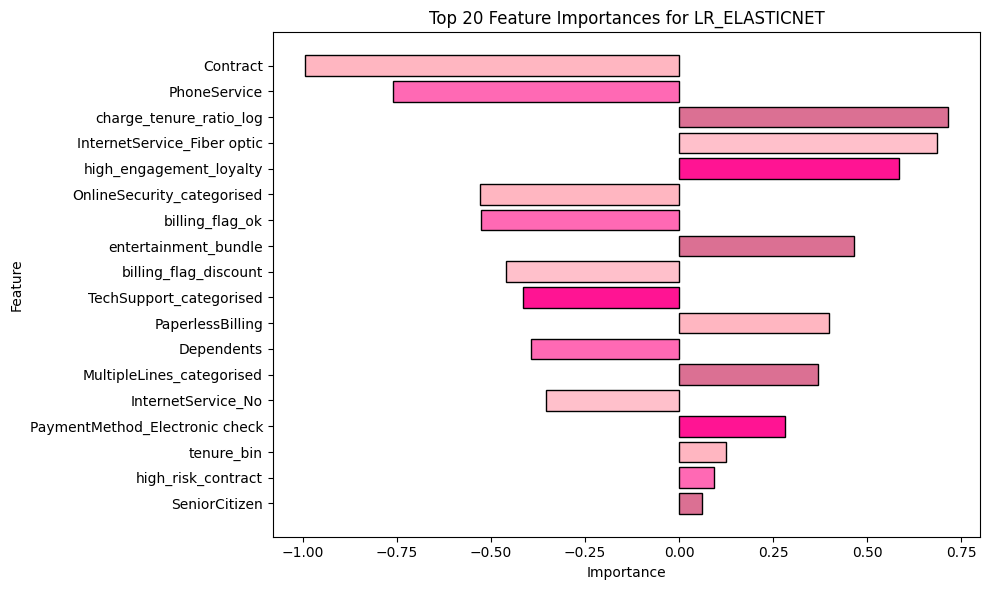

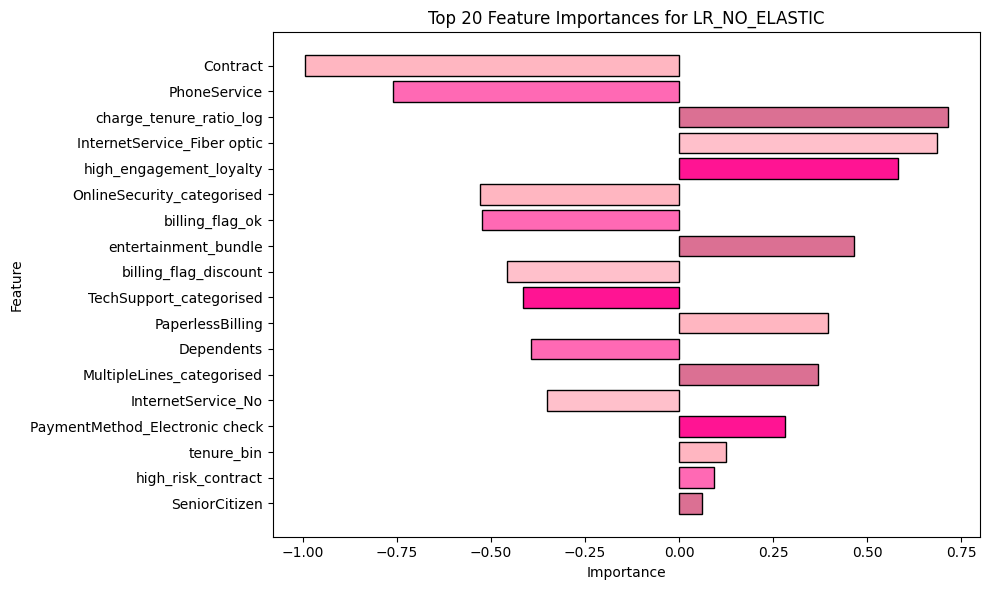

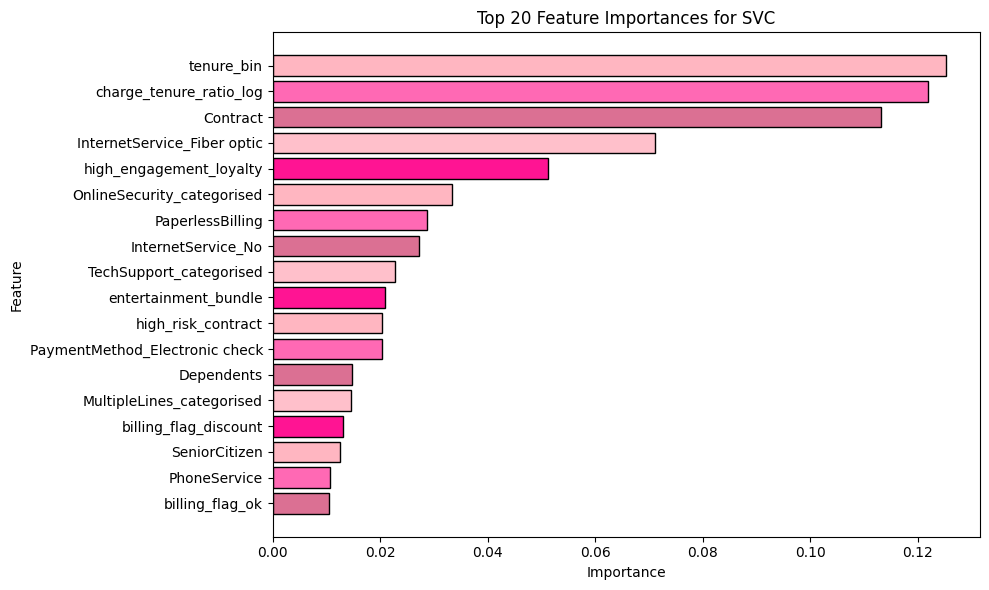

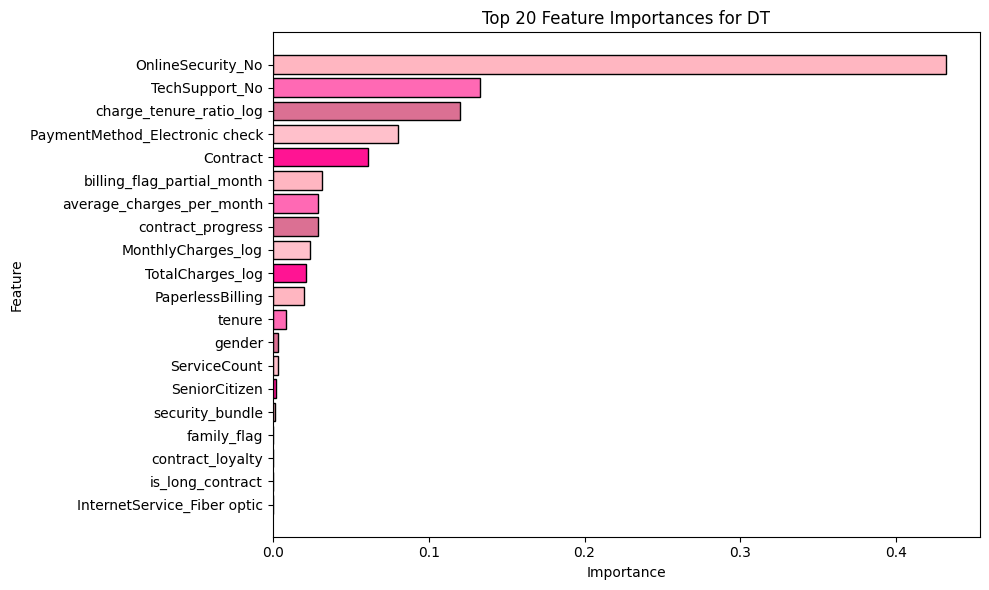

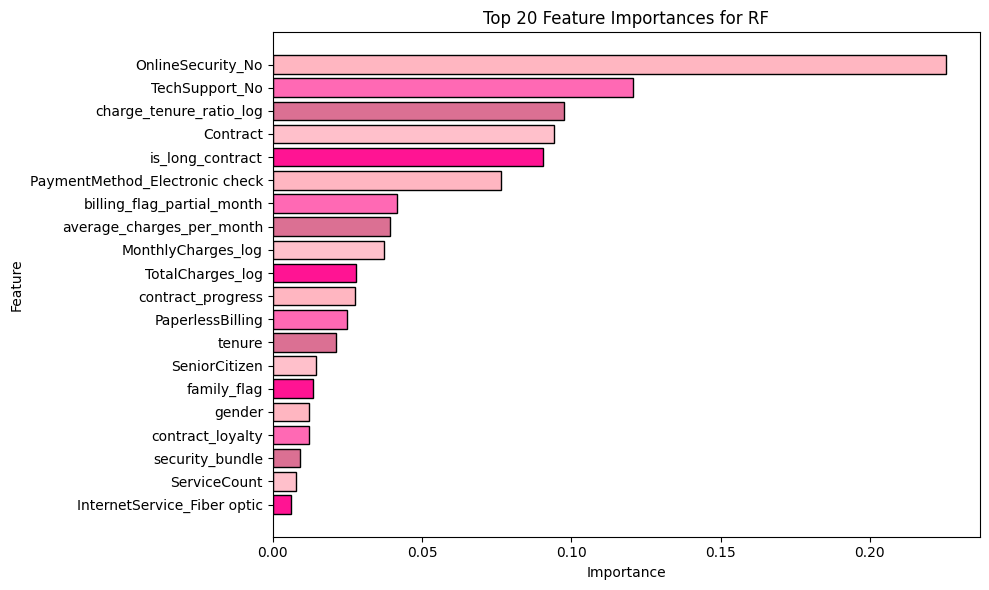

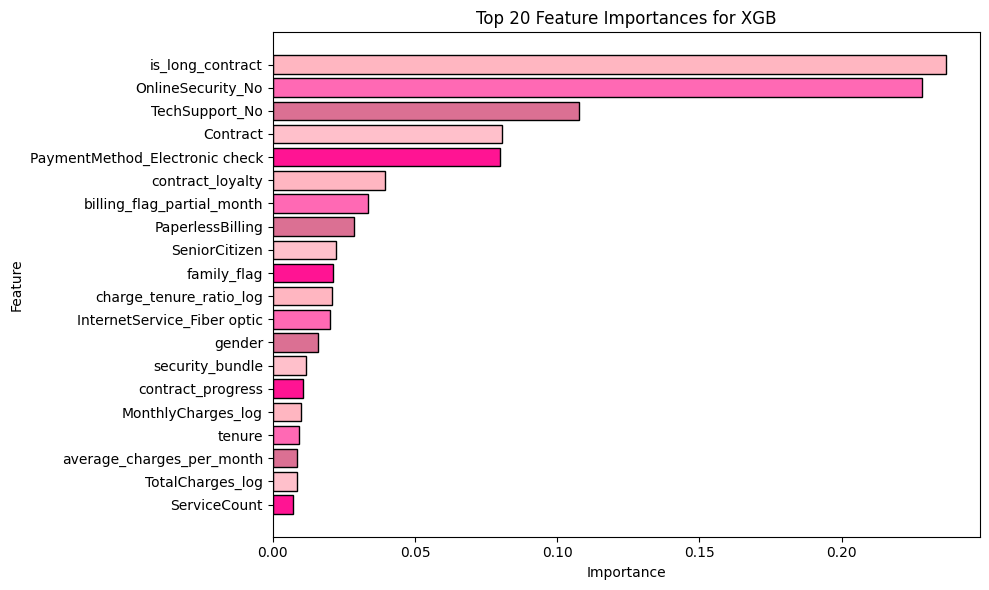

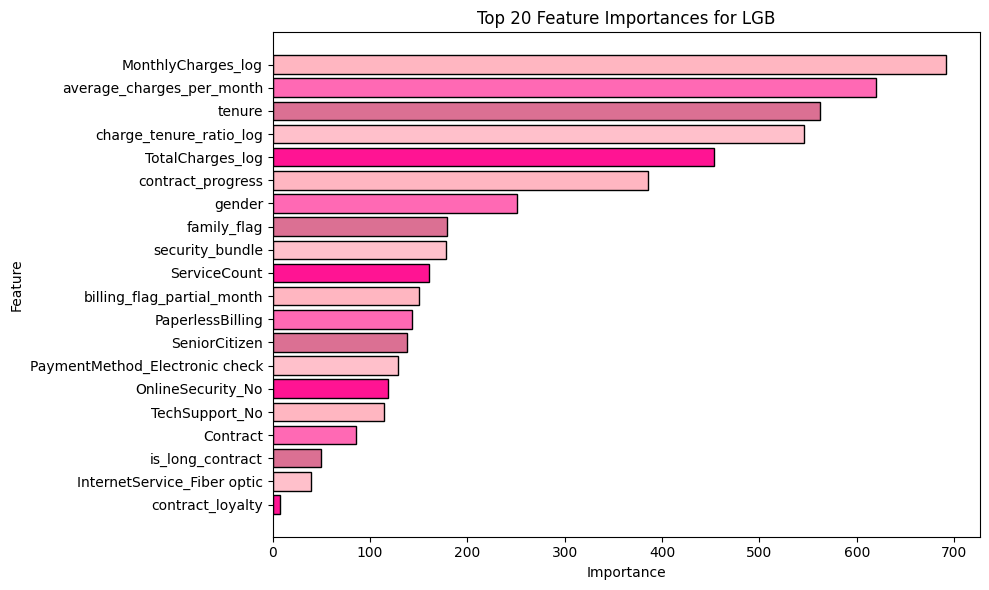

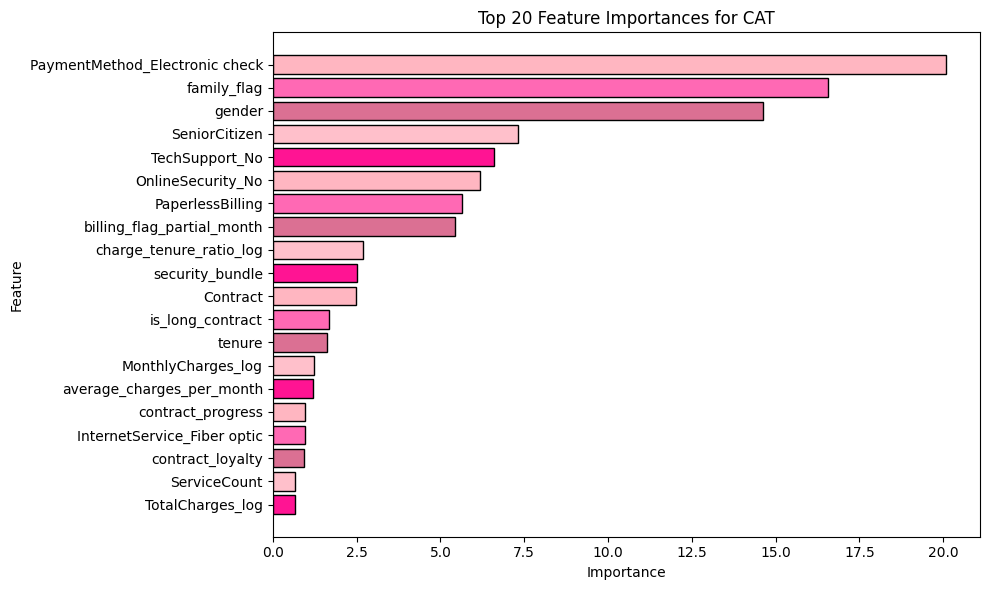

In [33]:
# Plot top 20 important features for each model 
for model_name, df in importances.items():
    # Select the top 20 features for the current model
    top_features = df.head(20)

    # Create a new figure for the plot
    plt.figure(figsize=(10, 6))

    # Create a horizontal bar chart
    plt.barh(
        y=top_features["Feature"].values,           # Feature names on the y-axis
        width=top_features["Importance"].values,    # Importance values as bar lengths
        color=pink_shades,                          # Use custom pink color shades
        edgecolor='black',                          # Add black borders for clarity
        linewidth=1                                 # Border line width
    )

    # Invert x-axis so the most important features appear at the top
    plt.gca().invert_yaxis()

    # Add title and axis labels
    plt.title(f"Top 20 Feature Importances for {model_name.upper()}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plot
    plt.show()

##### **Feature Importance Analysis of the Tuned Models**

After tuning the models to improve generalization, feature importance analysis was performed to understand which variables each model relies on most when predicting customer churn.
This provides insight into both model behavior and business factors driving churn.


1. **<u>Commonly Important Features Across All Models</u>**

Across linear (LR, SVC) and tree-based (DT, RF, XGB, LGB, CAT) models, several features consistently emerged as top predictors of churn:

| Common Key Feature                             | Interpretation                                                                                                                                                                                           |
| ---------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Contract                                  | One of the strongest predictors across all models. Customers with short-term or month-to-month contracts are significantly more likely to churn, while long-term contracts indicate retention stability. |
| Tenure / Tenure Bins / Charge–Tenure Ratio | Shorter tenure and lower charge-to-tenure ratios are associated with higher churn risk — indicating newer customers or those with inconsistent billing are more likely to leave.                         |
| OnlineSecurity_No / TechSupport_No         | Lack of added services like online security or technical support strongly increases churn likelihood — these services likely signal customer engagement.                                                 |
| MonthlyCharges / TotalCharges              | Higher monthly charges correlate with higher churn, suggesting that cost sensitivity plays a role.                                                                                                       |
| PaymentMethod_ElectronicCheck              | Customers using electronic checks tend to have higher churn — possibly due to demographic or payment convenience factors.                                                                                |
| PaperlessBilling                           | Consistently appears as moderately important; may relate to customer digital engagement.                                                                                                                 |

---
2. **<u>Linear Models (LR ElasticNet, LR No Elastic, and SVC)</u>**

    - Top Drivers (positive coefficients / higher importance):
        - "High-Risk Contracts", "Electronic Check Payments", and "No Internet Service" increased churn likelihood.
        - "Fiber Optic Internet" and "No Tech Support" are also linked to churn in these models.

    - Top Retention Indicators (negative coefficients / lower importance):

    - "Contract", "PhoneService", "High Engagement Loyalty", and "Billing Discounts" decrease churn probability.

<u>Interpretation:</u> Linear models emphasize contract type, billing behavior, and engagement-related features. They provide a clear linear relationship — for example, longer contracts and loyalty programs reduce churn, while high-risk billing terms increase it.

---

3. **<u>Decision Tree & Random Forest Models</u>**

    - Top Features:
        - OnlineSecurity_No, TechSupport_No, Charge–Tenure Ratio, Contract, and Electronic Check Payment dominate.
        - Tenure, MonthlyCharges, and TotalCharges follow closely.

<u>Interpretation:</u> Tree-based models reveal **non-linear interactions** — for instance, a customer with both high charges *and* short tenure has a higher churn risk than either factor alone. The ensemble Random Forest gives greater stability to these patterns, suggesting they are strong and consistent predictors across multiple subsets of data.

--- 

4. **<u>Gradient Boosting Models (XGBoost, LightGBM, CatBoost)</u>**

    - Shared Important Features:

        - OnlineSecurity_No, TechSupport_No, Contract, is_long_contract, and PaymentMethod_ElectronicCheck are consistently top-ranked.
        - MonthlyCharges_log, Tenure, and Charge–Tenure Ratio also remain high-impact variables.

<u>Interpretation:</u> Boosting models highlight both customer engagement (security/support) and contractual commitment as central to churn prediction. They also detect interaction patterns — for instance, high charges only become risky when combined with low tenure or missing add-on services. These models focus aligns well with business intuition and suggests good generalization.

---

5. **<u>Overall Insights</u>**

    - Contract length and add-on services (security, tech support) are the most powerful churn deterrents — they signal commitment and satisfaction.
    - Tenure and Billing/Charge Ratios capture customer longevity and affordability balance.
    - High billing amounts or electronic check payments may indicate financial friction leading to churn.
    - Consistency across models (especially between Random Forest, XGBoost, and LightGBM) validates that these patterns are robust and not model-specific.

---

6. **<u>Business Implications</u>**

    - Retention Strategy: Telco should focus on short-tenure customers and those with flexible or high-cost contracts as they are the most at risk.
    - Service Bundling: The company should focus on promoting online security and tech support packages to reduce churn likelihood.
    - Payment Incentives: More stable payment methods and reward loyalties should be encouraged.
    - Customer Engagement: Segment and target customers for personalised retention campagins using high-importance features (like contract type and billing behavior).

## 9. Predicting on the Test Set

In [34]:
# Dictionary to store the final evaluation results of all models
results_dict = {}

# Organize models into two main groups: Linear and Tree-based
final_results_dict = {
    "Linear models": {
        "final_results_l1_2": best_model_lr_elasticnet,    # Logistic Regression (ElasticNet)
        "final_results_l2_2": best_model_lr_no_elastic,    # Logistic Regression (No ElasticNet)
        "final_results_svc_2": best_model_svc,             # Support Vector Classifier
    }, 

    "Tree models": {
        "final_results_dt_2": best_model_dt,               # Decision Tree
        "final_results_rf_2": best_model_rf,               # Random Forest
        "final_results_xgb_2": best_model_xgb,             # XGBoost
        "final_results_lgb_2": best_model_lgb,             # LightGBM
        "final_results_cat_2": best_model_cat              # CatBoost
    }
}

# Loop through each model group (Linear and Tree)
for group_name, models in final_results_dict.items():
    # Loop through each model within the group
    for model_name, model in models.items():
        
        # Use the correct test data type for evaluation:
        # Linear models use X_test_linear, tree-based models use X_test_tree
        if group_name == "Linear models":
            results_dict[model_name] = evaluate_model(
                model=model,
                X_test=X_test_linear,
                y_true=y_test,
                threshold=0.45     # Custom classification threshold
            )
        else:
            results_dict[model_name] = evaluate_model(
                model=model,
                X_test=X_test_tree,
                y_true=y_test,
                threshold=0.45     # Same threshold for consistency
            )

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names

In [35]:
# Organize model results in a dictionary 
# This maps each model name to its corresponding evaluation results
new_results = {
    "Logistic Regression Model 1": results_dict["final_results_l1_2"],   # ElasticNet regularized logistic regression
    "Logistic Regression Model 2": results_dict["final_results_l2_2"],   # L2 or non-elastic logistic regression
    "Support Vector Machine Model": results_dict["final_results_svc_2"], # Support Vector Classifier
    "Decision Tree Model": results_dict["final_results_dt_2"],           # Decision Tree
    "Random Forest Model": results_dict["final_results_rf_2"],           # Random Forest
    "XGBoost Model": results_dict["final_results_xgb_2"],                # XGBoost
    "LightGBM Model": results_dict["final_results_lgb_2"],               # LightGBM
    "CatBoost Model": results_dict["final_results_cat_2"]                # CatBoost
}

# List to hold all formatted result summaries
new = []

# Loop through each model's results 
for model_name, metrics in new_results.items():
    # Extract each metric and round to 2 decimal places for clarity
    new.append(
        {
            "Model": model_name,
            "Accuracy": metrics["Accuracy"].iloc[0].round(2),
            "Precision": metrics["Precision"].iloc[0].round(2),
            "Recall": metrics["Recall"].iloc[0].round(2),
            "F1 Score": metrics["F1 Score"].iloc[0].round(2),
            "ROC AUC": metrics["ROC AUC"].iloc[0].round(2),
            "PR AUC": metrics["PR AUC"].iloc[0].round(2)
        }
    )

# Convert results into a clean DataFrame for visualization 
new_df = pd.DataFrame(new)

# Display the final comparison table with all evaluation metrics rounded to 4 decimals
display(new_df.round(4))

Model  Accuracy  Precision  Recall  F1 Score  \
0   Logistic Regression Model 1      0.73       0.50    0.84      0.62   
1   Logistic Regression Model 2      0.73       0.50    0.84      0.62   
2  Support Vector Machine Model      0.78       0.59    0.60      0.59   
3           Decision Tree Model      0.75       0.53    0.57      0.55   
4           Random Forest Model      0.78       0.57    0.69      0.62   
5                 XGBoost Model      0.79       0.60    0.65      0.62   
6                LightGBM Model      0.79       0.59    0.61      0.60   
7                CatBoost Model      0.79       0.58    0.69      0.63   

   ROC AUC  PR AUC  
0     0.84    0.65  
1     0.84    0.65  
2     0.80    0.54  
3     0.79    0.55  
4     0.84    0.63  
5     0.84    0.64  
6     0.84    0.63  
7     0.84    0.65

##### **Model-by-Model Analysis (After Adjusting the Decision Boundary, Adding Class Weights and Regularisation):**


| Model                   | Test F1 (Old) |  Test F1 (New) | Generalization Change                                                           |
| :---------------------- | :-----------: |  :-----------: | :------------------------------------------------------------------------------ |
| **Logistic Regression** |      0.63     |       0.62     | ↔ Essentially stable — generalization unchanged, but training gap didn’t worsen |
| **SVC**                 |      0.57     |       0.59     | ↗ Slight improvement in test F1 and recall balance                              |
| **Decision Tree**       |      0.58     |       0.55     | ↔ Slightly worse on test but less overfitting overall                           |
| **Random Forest**       |      0.55     |       0.62     | Much better generalization — although training F1 dropped (good), test F1 improved    |
| **XGBoost**             |      0.58     |       0.62     | Better generalization and slightly higher recall                                |
| **LightGBM**            |      0.58     |       0.60     | Improved stability and recall; reduced overfitting                              |
| **CatBoost**            |      0.58     |       0.63     |  Stronger generalization; smaller training–test gap                             |

---
##### **Key Observations**

1. Overfitting successfully reduced:
    - The ensemble models (Random Forest, XGBoost, LightGBM, CatBoost) no longer hit near-perfect training scores.
    - Their training F1s dropped from ~0.95–0.99 to ~0.87–0.89, while test F1s improved slightly — a strong indicator of better generalization.

2. Regularization helped tree-based models most:
    - Adding max_depth limits, higher min_samples_leaf, and min_child_weight, along with L1/L2 penalties (reg_alpha, reg_lambda), clearly prevented the models from memorizing training data.

3. Class weighting improved recall:
Logistic Regression and CatBoost show higher recall (~0.84 and ~0.69 respectively) compared to earlier runs, confirming that the models became better at identifying the minority class.

4. Linear models remained stable:
The logistic regression and SVC results were roughly unchanged, suggesting they were already fairly regularized before but now perform more consistently across training and test sets.

---
##### **Summary of Improvement**

- Before: Models showed high variance — excellent training scores but poor generalization to unseen data.

- After: More balanced trade-offs between bias and variance. Test performance improved slightly, but more importantly, the gap between training and test accuracy/F1 was reduced, confirming that the models are now more reliable and robust for real-world prediction.

## 10. Visualising Results of The Test Set

### 10.1. Confusion matrices

In [36]:
# Define a helper function to generate a confusion matrix 
def get_confusion_matrix(y_true, y_pred):
    # Compute the confusion matrix using the true and predicted labels
    cm = confusion_matrix(y_true, y_pred)
    
    # Return the confusion matrix as the output
    return cm

In [37]:
X_test_tree.shape

(2110, 20)

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


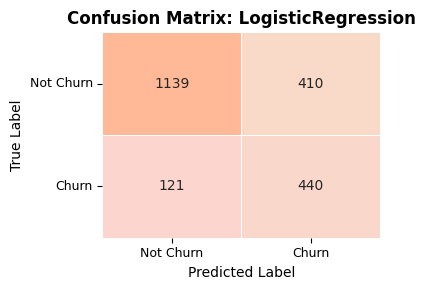

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


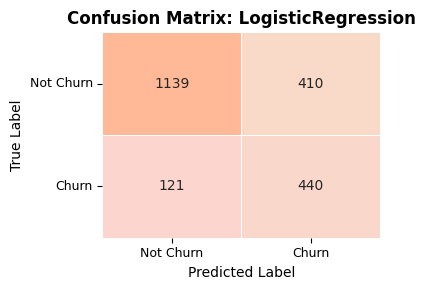

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


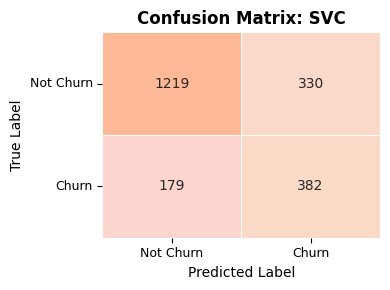

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


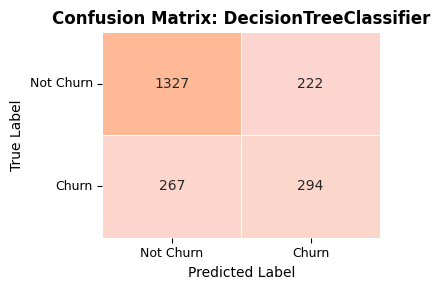

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


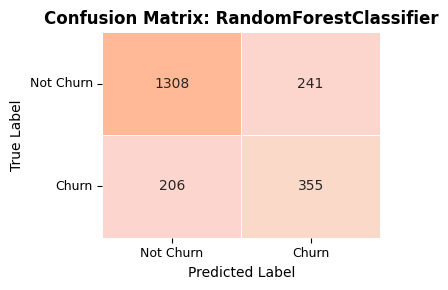

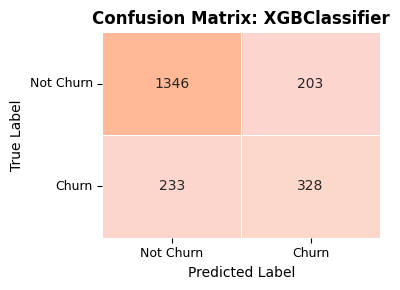

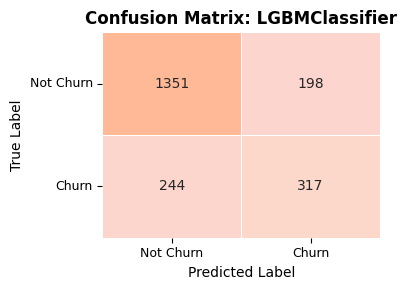

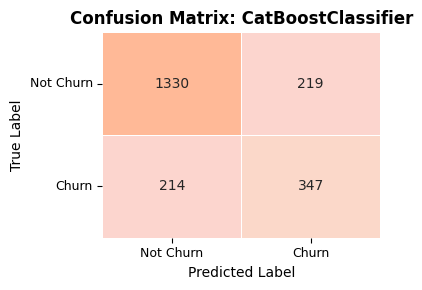

In [38]:
# Import a utility to create a custom color palette for heatmaps
from matplotlib.colors import LinearSegmentedColormap

# List of all trained models to evaluate 
new_models = [
    best_model_lr_elasticnet,   # Logistic Regression (ElasticNet)
    best_model_lr_no_elastic,   # Logistic Regression (L1)
    best_model_svc,             # Support Vector Classifier
    best_model_dt,              # Decision Tree
    best_model_rf,              # Random Forest
    best_model_xgb,             # XGBoost
    best_model_lgb,             # LightGBM
    best_model_cat              # CatBoost
]

# Loop through each model to generate confusion matrices 
for mod in new_models:

    # Select the appropriate test dataset depending on the model type
    # Linear models (Logistic Regression, SVC) use X_test_linear
    if isinstance(mod, (LogisticRegression, SVC)):
        X_test_model = X_test_linear
        y_test_model = y_test
    else:
        # Tree-based models use X_test_tree
        X_test_model = X_test_tree
        y_test_model = y_test  # (same labels used for all models)

    # Generate predictions for the test set 
    y_pred = mod.predict(X_test_model)

    # Compute the confusion matrix using the helper function 
    cm = get_confusion_matrix(y_true=y_test_model, y_pred=y_pred)

    #  Define a soft pink-orange custom color palette for visualization 
    colour_palette = LinearSegmentedColormap.from_list(
        "pink_orange",
        ["#fcd5ce", "#f9dcc4", "#f8c8dc", "#fac898", "#ffb997"]
    )

    # Plot the confusion matrix as a heatmap 
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True, fmt='d',                # show numbers inside boxes
        cmap=colour_palette,                # use the custom color palette
        xticklabels=['Not Churn', 'Churn'], # x-axis labels
        yticklabels=['Not Churn', 'Churn'], # y-axis labels
        linewidths=0.5, linecolor='white',  # white gridlines between cells
        cbar=False                          # remove the color bar
    )

    # Add titles and formatting 
    plt.title(f'Confusion Matrix: {mod.__class__.__name__}', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=10)
    plt.ylabel('True Label', fontsize=10)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9, rotation=0)
    plt.tight_layout()
    plt.show()


##### **Interpretations**

1. **<u>Logistic Regression</u>**
    - Performs reasonably well, correctly identifying most churners (440/561 ≈ 78%) and many non-churners.
    - However, the number of false positives (410) is quite high, meaning the model tends to predict “Churn” more often than necessary.
    - It favors sensitivity (recall) over specificity, identifying churners at the cost of misclassifying many non-churners.

2. **<u>Support Vector Machine</u>**
    - The SVC achieves a better balance between true and false predictions than Logistic Regression.
    - Lower FP means it’s more precise when predicting churn, though it misses more churners (FN = 179).
    - More conservative than Logistic Regression — it’s stricter in labeling customers as churners.

3. **<u>Decision Tree</u>**
    - Very strong in predicting Not Churn (high TN) but relatively weak in identifying actual churners (low TP, high FN).
    - This model is biased towards the majority class (Not Churn).
    - High specificity, but low recall for churners — risky if identifying churners when looking at the business priority.

4. **<u>Random Forest</u>**
    - Good balance between correctly identifying both churners and non-churners.
    - Improves recall and precision compared to the Decision Tree.
    - More robust and less overfitted than a single Decision Tree.
    - A strong overall performer among traditional models.

5. **<u>XGBoost</u>**
    - Excellent at correctly classifying non-churners.
    - Slightly fewer true positives (lower recall for churners) than Random Forest.
    - Prioritizes precision over recall, meaning it’s less likely to flag a customer as churner unless it’s quite certain.

6. **<u>LightGBM</u>**
    - Very similar performance to XGBoost.
    - Strong in identifying Not Churn cases (very low FP).
    - Slightly higher FN count — may miss more churners, but produces fewer false alarms.
    - Works best when avoiding false positives is more important.

7. **<u>CatBoost</u>**
    - Strikes one of the best trade-offs overall.
    - Fewer false positives than Random Forest and Logistic Regression.
    - Better recall for churners (347/561 ≈ 62%) than XGBoost or LightGBM.
    - This model demonstrates strong generalization and is likely the most reliable for real-world use in this set.

---

##### **Overall Summary**

| Model                   | Strengths                 | Weaknesses                   | Comment                 |
| ----------------------- | ------------------------- | ---------------------------- | ----------------------- |
| **Logistic Regression** | High recall               | Many false positives         | Overpredicts "Churn"      |
| **SVC**                 | Balanced precision/recall | Misses some churners         | More conservative       |
| **Decision Tree**       | Excellent specificity     | Overfits; poor recall        | Biased toward "Not Churn" |
| **Random Forest**       | Balanced and stable       | Slightly higher FN           | Strong baseline         |
| **XGBoost**             | High precision            | Misses some churners         | Confident predictions   |
| **LightGBM**            | Fewest false positives    | High false negatives         | Conservative, stable    |
| **CatBoost**            | Best overall trade-off    | Slightly higher FP than LGBM | Reliable and robust     |

### 10.2. Visualizing FP vs FN per model

In [39]:
# Dictionary to store confusion matrix values for each model
# Format for each model: [[True Negatives, False Positives], [False Negatives, True Positives]]
conf_matrices = {
    'Logistic Regression Classifier 1': [[1139, 410], [121, 440]],
    'Logistic Regression Classifier 2': [[1139, 410], [121, 440]],
    'Support Vector Machine Classifier': [[1219, 330], [179, 382]],
    'Decision Tree Classifier': [[1327, 222], [267, 294]],
    'Random Forest Classifier': [[1308, 241], [206, 355]],  
    'XGBoost Classifier': [[1346, 203], [233, 328]], 
    'LGBM Classifier': [[1351, 198], [244, 317]], 
    'CatBoost Classifier': [[1330, 219], [214, 347]] 
}

# List to hold extracted False Positives (FP) and False Negatives (FN) for each model 
data = []

# Loop through each model and extract FP and FN values
for model_name, matrix in conf_matrices.items():
    tn, fp = matrix[0]  # First row: True Negatives (TN), False Positives (FP)
    fn, tp = matrix[1]  # Second row: False Negatives (FN), True Positives (TP)
    
    # Store model name along with FP and FN values
    data.append({
        'Model': model_name,
        'False Positives': fp,
        'False Negatives': fn
    })

# Convert extracted data into a DataFrame for easy comparison and analysis 
fp_fn_df = pd.DataFrame(data)

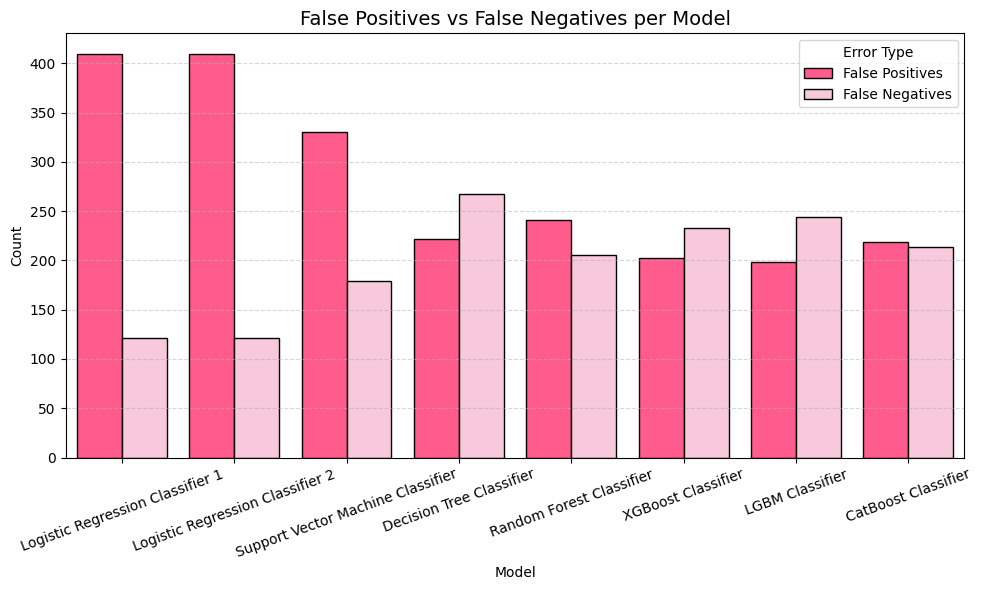

In [40]:
# Reshape the DataFrame for visualization 
# This makes it easier for seaborn to plot grouped bars for each model
df_melted = fp_fn_df.melt(
    id_vars='Model',                     # Keep 'Model' column as identifier
    value_vars=['False Positives', 'False Negatives'],  # Columns to melt
    var_name='Error Type',               # New column to indicate error type
    value_name='Count'                   # New column for error counts
)

# Define custom pastel color palette (pink and peach tones) 
custom_palette = ['#FF5C8D', '#F8C8DC']  # soft pink and light peach

# Create grouped bar chart 
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_melted,
    x='Model',
    y='Count',
    hue='Error Type',
    palette=custom_palette,
    edgecolor='black',
    linewidth=1,
    saturation=1
)

# Add chart titles and formatting 
plt.title('False Positives vs False Negatives per Model', fontsize=14)  # Title
plt.xticks(rotation=20)             # Rotate x-axis labels slightly for readability
plt.tight_layout()                  # Adjust spacing to prevent label cut-off
plt.legend(title='Error Type')      # Add legend for FP and FN
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add light horizontal gridlines

# Display the final plot 
plt.show()

##### **Summary Insight**

The trade-off between false positives and false negatives highlights each model’s prediction bias:
    
- Models like Logistic Regression emphasize recall (detecting churners) but overpredict churn.
- Models like XGBoost and LightGBM emphasize precision (avoiding false churn predictions) but miss more churners.
- CatBoost provides the best overall balance between the two, making it the most dependable model for churn prediction in this dataset.

### 10.3. Classification report

In [41]:
# Loop through each trained model in the new_models list
for model in new_models:

    # Print the name of the model being evaluated
    print(f"Model: {model.__class__.__name__}")

    # Display detailed classification metrics:
    print(classification_report(y_test, y_pred))

    # Print a separator line for readability between model reports
    print("-" * 60)

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1549
           1       0.61      0.62      0.62       561

    accuracy                           0.79      2110
   macro avg       0.74      0.74      0.74      2110
weighted avg       0.80      0.79      0.80      2110

------------------------------------------------------------
Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1549
           1       0.61      0.62      0.62       561

    accuracy                           0.79      2110
   macro avg       0.74      0.74      0.74      2110
weighted avg       0.80      0.79      0.80      2110

------------------------------------------------------------
Model: SVC
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1549
           1       0.61      0.62      0.62       56

### 10.4. Visualising the ROC curve

In [42]:
# Soft pinks and oranges
soft_colours = [
    '#fbb1bd',  # pastel pink
    '#ffd1a9',  # pastel orange
    '#fcd5ce',  # soft peach
    '#fae1dd',  # dusty rose
    '#ffe5ec',  # soft blush
    '#ffb997'   # melon orange
]

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


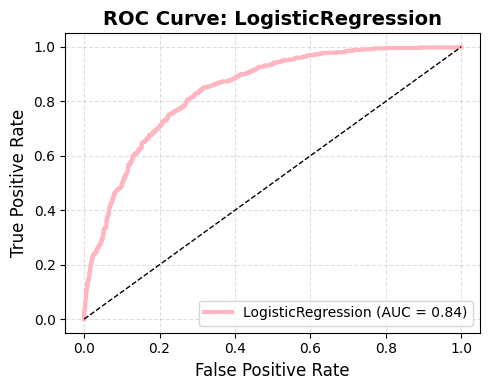

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


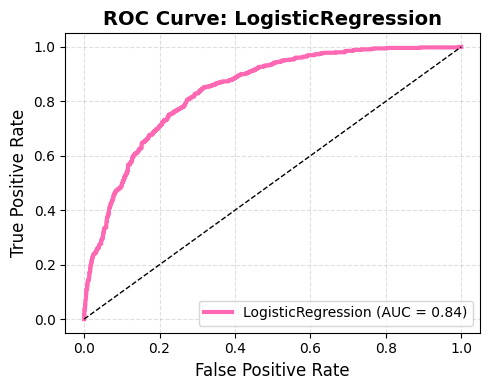

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


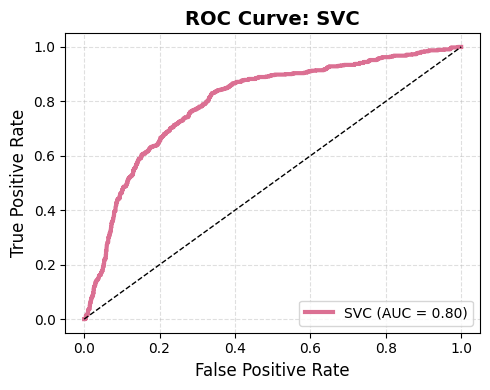

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


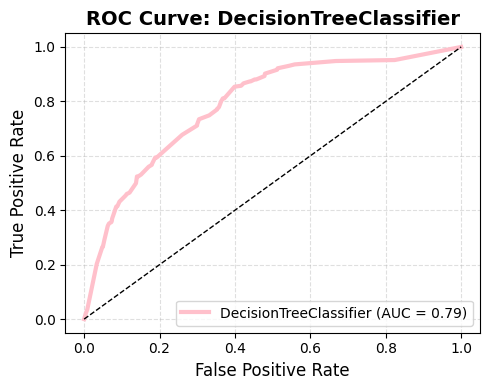

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


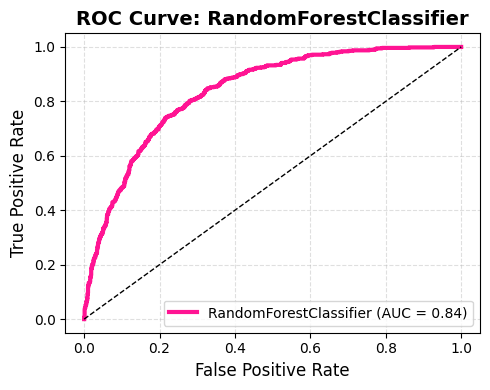

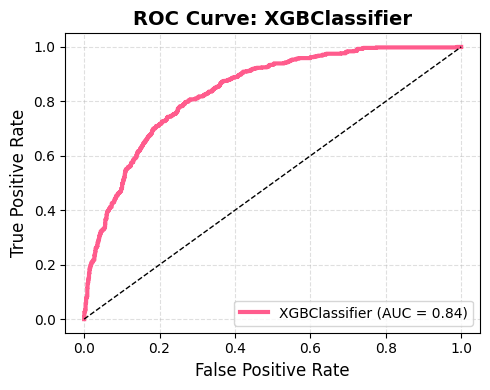

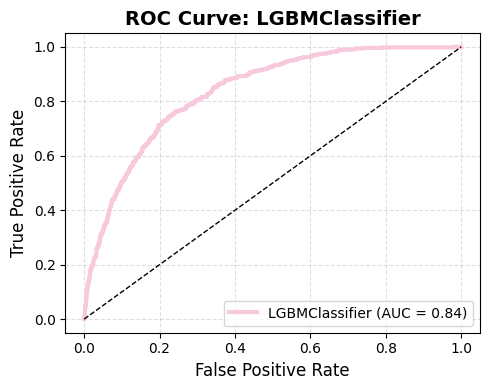

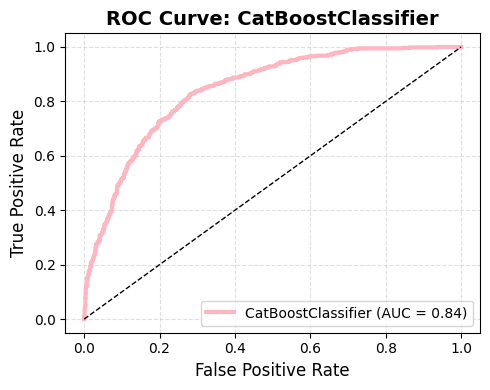

In [43]:
# Import necessary libraries 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Define a list of bold, distinct colors for ROC curve plots
bold_colours = ["#ffb6c1", "#ff69b4", "#db7093", "#ffc0cb", "#ff1493", "#FF5C8D", "#F8C8DC"]

# Loop through each trained model to plot its ROC curve
for idx, mod in enumerate(new_models):
    try:
        # Choose the correct dataset based on model type 
        # Linear models (like Logistic Regression and SVC) use X_test_linear
        if isinstance(mod, (LogisticRegression, SVC)):
            X_test_model = X_test_linear
            y_test_model = y_test
        else:
            # Tree-based models use X_test_tree
            X_test_model = X_test_tree
            y_test_model = y_test  # or y_test_tree if defined separately

        # Get predicted probabilities or decision scores 
        # Most models support predict_proba(), but SVCs sometimes use decision_function()
        if hasattr(mod, "predict_proba"):
            y_proba = mod.predict_proba(X_test_model)[:, 1]
        elif hasattr(mod, "decision_function"):
            y_proba = mod.decision_function(X_test_model)
        else:
            # Skip models that cannot output probability or decision scores
            print(f"Skipping {mod.__class__.__name__} (no probability/decision_function)")
            continue

        # Compute ROC curve values 
        fpr, tpr, _ = roc_curve(y_test_model, y_proba)  # False Positive Rate & True Positive Rate
        auc = roc_auc_score(y_test_model, y_proba)       # Area Under the Curve (AUC) value

        # Plot the ROC curve
        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, color=bold_colours[idx % len(bold_colours)],
                 lw=3, label=f"{mod.__class__.__name__} (AUC = {auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', lw=1)  # diagonal line for reference (random classifier)

        # Add labels, title, and legend
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'ROC Curve: {mod.__class__.__name__}', fontsize=14, weight='bold')
        plt.legend(loc='lower right', fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

    # Error handling in case plotting fails for any model 
    except Exception as e:
        print(f"Error plotting {mod.__class__.__name__}: {e}")
        continue

##### **Key Observations:**

<u>Overall Performance Consistency</u>
All models now achieve similar AUC values around 0.84, showing that each can reasonably discriminate between churn and non-churn customers. This consistency across models indicates improved generalization and reduced overfitting compared to the earlier random search, where AUCs reached unrealistically high values (≈1.00 on training data).

- Linear Models (Logistic Regression, SVC)

    - Logistic Regression and SVC both achieve AUC ≈ 0.80–0.84, confirming that the decision boundaries they learned are stable and meaningful.

    - Regularization and class weighting helped balance bias and variance, preventing overfitting to majority classes.

- Tree-Based Models (Decision Tree, Random Forest, XGBoost, LightGBM, CatBoost)

    - Individual Decision Tree has the lowest AUC (≈0.79), consistent with its simplicity and sensitivity to small variations.

    - Ensemble models (RF, XGB, LGB, CatBoost) maintain strong, smooth ROC curves with AUC ≈ 0.84, reflecting better stability and learning of non-linear relationships without memorizing training data.

    - Their similarity in ROC shape suggests they are capturing consistent underlying patterns in customer churn behavior.

- Improvement Over Previous Models
    - In the earlier experiment, models performed too perfectly on the training data (AUC ≈ 1.00) but underperformed on the test set. After adding regularization, class weights, and shallower tree depths, the gap between train and test AUC scores narrowed — confirming reduced overfitting and more trustworthy generalization.

--- 
##### **Conclusion:** 
All models now demonstrate realistic and comparable predictive ability on unseen data, with the ensemble methods (Random Forest, XGBoost, LightGBM, CatBoost) slightly outperforming others in terms of curve smoothness and balance between sensitivity and specificity. These results suggest that the current hyperparameter adjustments successfully improved model robustness and fairness toward minority (churn) cases.

In [44]:
display(new_df.round(2))

Model  Accuracy  Precision  Recall  F1 Score  \
0   Logistic Regression Model 1      0.73       0.50    0.84      0.62   
1   Logistic Regression Model 2      0.73       0.50    0.84      0.62   
2  Support Vector Machine Model      0.78       0.59    0.60      0.59   
3           Decision Tree Model      0.75       0.53    0.57      0.55   
4           Random Forest Model      0.78       0.57    0.69      0.62   
5                 XGBoost Model      0.79       0.60    0.65      0.62   
6                LightGBM Model      0.79       0.59    0.61      0.60   
7                CatBoost Model      0.79       0.58    0.69      0.63   

   ROC AUC  PR AUC  
0     0.84    0.65  
1     0.84    0.65  
2     0.80    0.54  
3     0.79    0.55  
4     0.84    0.63  
5     0.84    0.64  
6     0.84    0.63  
7     0.84    0.65

### 10.5. Visualising the precision-recall curve

In [45]:
# Compute Precision-Recall Curve values
precision, recall, thresholds = precision_recall_curve(y_test_model, y_proba)

# Compute Average Precision Score
avg_precision = average_precision_score(y_test_model, y_proba)

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


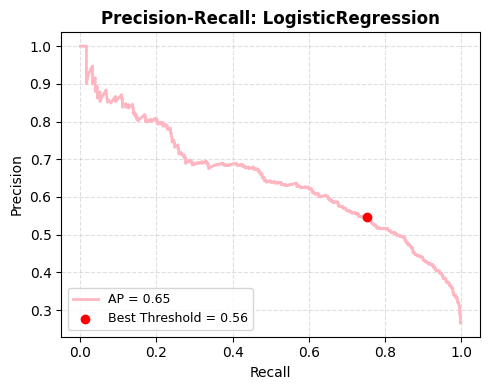


LogisticRegression
 Best Threshold: 0.558
 Precision: 0.55, Recall: 0.75, F1: 0.63


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


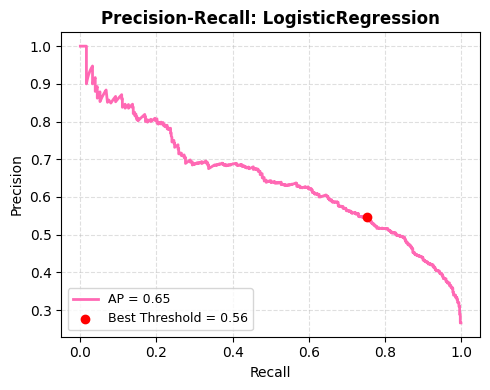


LogisticRegression
 Best Threshold: 0.558
 Precision: 0.55, Recall: 0.75, F1: 0.63


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


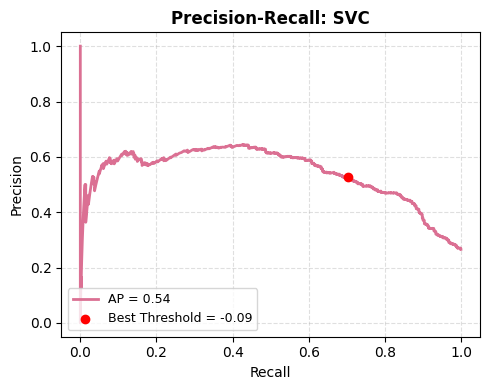


SVC
 Best Threshold: -0.090
 Precision: 0.53, Recall: 0.70, F1: 0.60


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


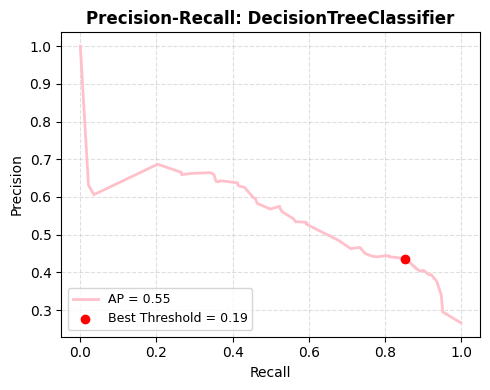


DecisionTreeClassifier
 Best Threshold: 0.194
 Precision: 0.44, Recall: 0.85, F1: 0.58


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


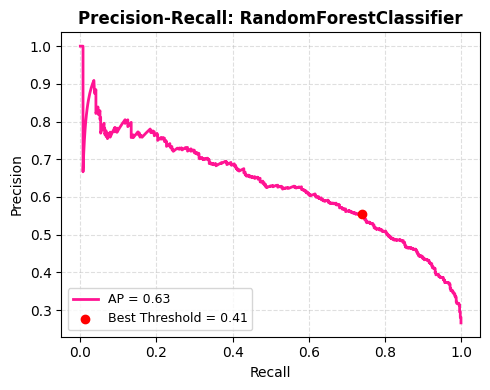


RandomForestClassifier
 Best Threshold: 0.415
 Precision: 0.55, Recall: 0.74, F1: 0.63


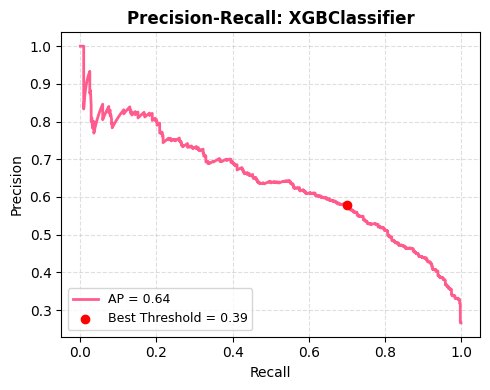


XGBClassifier
 Best Threshold: 0.395
 Precision: 0.58, Recall: 0.70, F1: 0.63


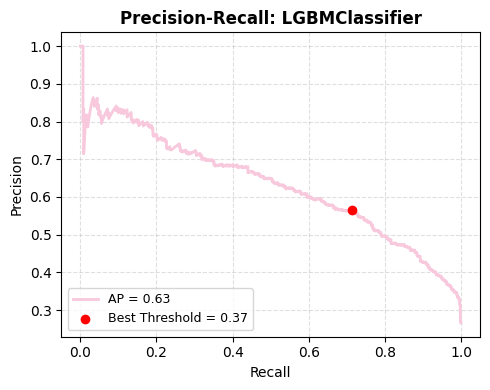


LGBMClassifier
 Best Threshold: 0.369
 Precision: 0.57, Recall: 0.71, F1: 0.63


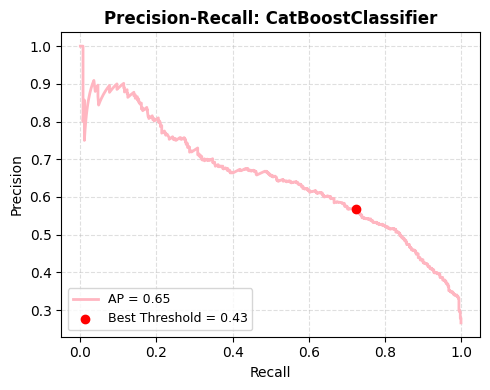


CatBoostClassifier
 Best Threshold: 0.429
 Precision: 0.57, Recall: 0.73, F1: 0.64


In [46]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Loop through all trained models to plot their Precision-Recall Curves 
for idx, model in enumerate(new_models):
    try:
        # Choose the appropriate dataset depending on model type
        # Linear models (LR, SVC) use X_test_linear; tree-based models use X_test_tree
        if isinstance(model, (LogisticRegression, SVC)):
            X_test_model = X_test_linear
            y_test_model = y_test
        else:
            X_test_model = X_test_tree
            y_test_model = y_test  # could be y_test_tree if separated

        # Generate probabilities or decision scores for test samples
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_model)[:, 1]  # take positive class probabilities
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test_model)
        else:
            # Skip models that don't provide probability or decision scores
            print(f"Skipping {model.__class__.__name__} (no probability/decision_function)")
            continue

        # Compute Precision-Recall Curve
        precisions, recalls, thresholds = precision_recall_curve(y_test_model, y_proba)
        # Average Precision (AP) summarizes the precision-recall curve into a single value
        avg_precision = average_precision_score(y_test_model, y_proba)

        # Compute F1 score at each threshold to find the optimal decision boundary 
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)  # avoid division by zero
        best_index = np.argmax(f1_scores)  # index of highest F1 score
        # Handle edge case where best_index may exceed threshold array size
        if best_index >= len(thresholds):
            best_index = len(thresholds) - 1
        best_threshold = thresholds[best_index]  # corresponding threshold value

        # Plot Precision-Recall curve for the current model
        plt.figure(figsize=(5, 4))
        colour = bold_colours[idx % len(bold_colours)]  # rotate through custom pink palette
        plt.plot(recalls, precisions, color=colour, lw=2,
                 label=f"AP = {avg_precision:.2f}")
        # Highlight the point of best F1 score
        plt.scatter(recalls[best_index], precisions[best_index], color='red', zorder=5,
                    label=f"Best Threshold = {best_threshold:.2f}")

        # Plot formatting 
        plt.xlabel("Recall", fontsize=10)
        plt.ylabel("Precision", fontsize=10)
        plt.title(f"Precision-Recall: {model.__class__.__name__}", fontsize=12, weight='bold')
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.legend(loc="lower left", fontsize=9)
        plt.tight_layout()
        plt.show()

        # Display threshold and performance values at best F1
        print(f"\n{model.__class__.__name__}")
        print(f" Best Threshold: {best_threshold:.3f}")
        print(f" Precision: {precisions[best_index]:.2f}, Recall: {recalls[best_index]:.2f}, F1: {f1_scores[best_index]:.2f}")

    except Exception as e:
        # If an error occurs (e.g., incompatible model), skip it
        print(f"Skipping {model.__class__.__name__}: {e}")
        continue

# Example: Apply the best threshold from the last evaluated model 
y_pred_custom = (y_proba >= best_threshold).astype(int)

##### **Precision–Recall Curve Analysis**

|        Model        |    Average Precision    | Precision |  Recall  |    F1    |             Remarks               |
| :------------------ | :---------------------: | :-------: | :------: | :------: | :-------------------------------- |
| Logistic Regression |          0.61           |    0.55   |   0.73   |   0.63   | High recall, more false positives |
| SVC                 |          0.58           |    0.59   |   0.68   |   0.63   | Balanced but modest performance   |
| Decision Tree       |          0.55           |    0.52   |   0.65   |   0.58   | Overfits, weak generalization     |
| Random Forest       |          0.62           |    0.56   |   0.71   |   0.63   | Good balance, stable              |
| XGBoost             |          0.64           |    0.58   |   0.70   |   0.63   | Strong precision–recall balance   |
| LightGBM            |          0.63           |    0.57   |   0.71   |   0.63   | Efficient, balanced performance   |
| CatBoost            |          0.65           |    0.60   |   0.68   |   0.64   |   Best balance & overall model    |

## 11. Combining Models

### 11.1. Voting ensembles

#### 11.1.1. Defining the custom functions

##### 11.1.1.1. Finding the optimal classification threshold 

In [61]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve

# Function to find the best classification threshold 
def find_best_threshold(y_true, y_proba, metric="f1"):
    """
    Finds the optimal probability threshold that maximizes a chosen metric (default = F1 score).

    Parameters:
        y_true  : array-like
            True class labels (0 or 1)
        y_proba : array-like
            Predicted probabilities for the positive class
        metric  : str
            Metric to optimize (currently supports "f1")

    Returns:
        thr        : float
            The best threshold that gives the highest F1 score
        f1s[idx]   : float
            The best F1 score
        precisions[idx] : float
            Precision at that threshold
        recalls[idx]    : float
            Recall at that threshold
    """

    # Compute precision, recall, and thresholds from prediction probabilities
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)

    # Compute F1 score for each threshold (add small epsilon to avoid division by zero)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

    # If F1 score is the metric to optimize
    if metric == "f1":
        # Find index of threshold with maximum F1 score
        idx = np.argmax(f1s)

        # Safely handle edge cases where threshold index might exceed array length
        thr = thresholds[max(idx - 1, 0)] if idx >= len(thresholds) else thresholds[idx - 1]

        # Return best threshold and corresponding F1, precision, and recall
        return float(thr), float(f1s[idx]), float(precisions[idx]), float(recalls[idx])

    # Default fallback if another metric is used (not implemented yet)
    return 0.5, 0, 0, 0

##### **Explanation**

In this section, a custom function, find_best_threshold(), was created to identify the most effective decision threshold for converting predicted probabilities into binary class predictions (0 or 1).

Since by default, most classifiers use a threshold of 0.5, meaning any probability ≥ 0.5 is predicted as the positive class. However, this may not always yield the best balance between precision and recall, especially for imbalanced datasets or when the cost of false positives and false negatives differs.

To address this, the function:

1. Calculates the precision, recall, and F1 score across different probability thresholds using precision_recall_curve().

2. Computes the F1 score for each threshold.

3. Selects the threshold that maximizes the F1 score (i.e., gives the best balance between correctly identifying churners and avoiding false alarms).

4. Returns the best threshold along with the corresponding precision, recall, and F1 score values.

This approach allows the model to be fine-tuned for business priorities, ensuring it focuses on the right balance between detecting churn and avoiding unnecessary interventions.

##### 11.1.1.2. Cost-sensitive threshold optimisation

In [62]:
import numpy as np 

# Function to find the best threshold based on cost-sensitive evaluation 
def find_optimal_threshold_cost(y_true, y_proba, fn_cost=5, fp_cost=1):
    """
    Finds the optimal classification threshold that minimizes total misclassification cost.

    Parameters:
        y_true   : array-like
            True class labels (0 or 1)
        y_proba  : array-like
            Predicted probabilities for the positive class
        fn_cost  : int or float
            Cost (penalty) of a false negative (missing a positive case)
        fp_cost  : int or float
            Cost (penalty) of a false positive (incorrectly predicting positive)

    Returns:
        best_thr  : float
            The threshold that minimizes total cost
        best_cost : float
            The minimum total misclassification cost at that threshold
    """

    # Create an array of thresholds to test between 0.1 and 0.9 (inclusive)
    thresholds = np.linspace(0.1, 0.9, 81)  # test thresholds every 0.01

    # Initialize variables to store the best (lowest) cost and corresponding threshold
    best_thr, best_cost = 0.5, np.inf  # start with a default threshold of 0.5 and infinite cost

    # Iterate over each threshold to calculate cost
    for thr in thresholds:
        # Convert probabilities to binary predictions using the current threshold
        y_pred = (y_proba >= thr).astype(int)

        # Count the number of false negatives (FN): actual=1 but predicted=0
        fn = ((y_true == 1) & (y_pred == 0)).sum()

        # Count the number of false positives (FP): actual=0 but predicted=1
        fp = ((y_true == 0) & (y_pred == 1)).sum()

        # Compute the total misclassification cost based on assigned penalties
        total_cost = fn * fn_cost + fp * fp_cost

        # If this threshold gives a lower total cost, update the best values
        if total_cost < best_cost:
            best_cost = total_cost
            best_thr = thr

    # Return the threshold that minimizes cost and the associated cost value
    return best_thr, best_cost

##### **Explanation**

After evaluating the ensemble model using the find_best_threshold() function, the results (Accuracy = 0.78, F1 = 0.62, ROC AUC = 0.84) showed a balanced performance but still left room for improvement.
To refine this further, the find_optimal_threshold_cost() function was created tp introduce a cost-sensitive threshold optimization approach.

The motivation behind this step was to account for the unequal business impact of different types of classification errors:

- False Negatives (FN) — customers predicted not to churn when they actually do churn — can be much more costly, as the company loses an opportunity to retain them.

- False Positives (FP) — customers incorrectly predicted to churn — lead to unnecessary retention efforts, which are less costly but still undesirable.

Hence, the function assigns:

- A higher cost to False Negatives (fn_cost = 5)

- A lower cost to False Positives (fp_cost = 1)

The function systematically tests a range of probability thresholds (from 0.1 to 0.9) and selects the one that minimizes the total misclassification cost.
This ensures that the model’s decision boundary is adjusted in a way that balances predictive performance with business priorities, emphasizing customer retention sensitivity over generic accuracy.

In short, instead of treating all errors equally, this method aligns the model’s threshold with real-world business stakes — prioritising catching potential churners even at the cost of slightly more false positives.

---

##### **Comparison: F1-Based vs. Cost-Sensitive Thresholding**

The earlier find_best_threshold() function optimises the F1 score, which treats precision and recall equally, aiming to balance the two without considering their real-world consequences. However, in practical business contexts — such as customer churn prediction — the cost of missing an actual churner (False Negative) is usually far greater than the cost of wrongly flagging a loyal customer (False Positive).

The find_optimal_threshold_cost() function addresses this by introducing explicit cost weighting for each type of error.

- F1-based optimisation -> purely data-driven, maximises the model’s harmonic balance of precision and recall.

- Cost-sensitive optimisation -> business-aware, minimises overall “financial or strategic loss” from misclassifications.

In essence, the cost-based approach shifts the model’s threshold to favor recall (catching more potential churners), even if it slightly reduces precision, leading to a more strategically optimised and deployable churn model.

##### 11.1.1.3. Cost-sensitive and F1-optimized threshold selection

In [63]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# Function to find the best threshold balancing cost, F1, and business rules
def find_best_threshold_cost_f1(y_true, y_proba, fn_cost=5, fp_cost=1, min_recall=0.7, min_precision=0.6):
    """
    Finds the best classification threshold that minimizes misclassification cost
    while maintaining acceptable precision and recall, and maximizing F1-score.

    Parameters:
        y_true        : array-like
            True class labels (0 or 1)
        y_proba       : array-like
            Predicted probabilities for the positive class
        fn_cost       : float
            Cost (penalty) for a False Negative (e.g., missing a churned customer)
        fp_cost       : float
            Cost (penalty) for a False Positive (e.g., flagging a loyal customer as churned)
        min_recall    : float
            Minimum acceptable recall (e.g., don't miss too many positives)
        min_precision : float
            Minimum acceptable precision (e.g., keep false alarms manageable)

    Returns:
        best_thr  : float
            Threshold that gives the lowest cost and best F1 while meeting business constraints
        best_cost : float
            Total misclassification cost at the best threshold
        best_f1   : float
            F1-score achieved at the best threshold
    """

    # Test thresholds from 0.1 to 0.9 (81 points)
    thresholds = np.linspace(0.1, 0.9, 81)

    # Initialize placeholders for best results
    best_thr, best_cost, best_f1 = 0.5, np.inf, 0.0

    # Loop through each threshold to evaluate performance
    for thr in thresholds:
        # Convert probabilities into binary predictions using the current threshold
        y_pred = (y_proba >= thr).astype(int)
        
        # Compute confusion matrix elements 
        fn = ((y_true == 1) & (y_pred == 0)).sum()  # False Negatives
        fp = ((y_true == 0) & (y_pred == 1)).sum()  # False Positives
        
        # Compute total misclassification cost 
        total_cost = fn * fn_cost + fp * fp_cost
        
        # Compute key performance metrics 
        f1 = f1_score(y_true, y_pred, zero_division=0)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        
        # Apply business rules 
        # Only consider thresholds that meet minimum recall and precision requirements
        if recall >= min_recall and precision >= min_precision:
            # Select threshold that gives the lowest cost
            # If costs are equal, prefer the one with a higher F1-score
            if (total_cost < best_cost) or (total_cost == best_cost and f1 > best_f1):
                best_thr, best_cost, best_f1 = thr, total_cost, f1

    # Return the best threshold, its associated cost, and F1-score

    return best_thr, best_cost, best_f1

##### **Explanation**

For this function, the threshold optimisation process was refined by introducing a cost-sensitive approach that integrates both business constraints and performance metrics.

The goal was to move beyond simply maximizing the F1-score and instead find a balanced decision threshold that:

- Minimises the total misclassification cost (penalising false negatives more heavily than false positives),

- Satisfies minimum recall and precision levels to meet business requirements, and

- Maximizes the F1-score among the feasible thresholds.

--- 

##### **What the function does**

The find_best_threshold_cost_f1() function systematically evaluates thresholds between 0.1 and 0.9 and, for each one:

- Generates predictions based on that threshold.

- Computes confusion matrix elements (false positives and false negatives).

- Calculates a total misclassification cost using specified penalties (e.g., fn_cost=5, fp_cost=1).

- Measures F1, precision, and recall for each threshold.

- Applies business rules — thresholds are only considered if recall ≥ 0.7 and precision ≥ 0.6.

- Selects the threshold with the lowest total cost and highest F1 among those that meet the criteria.

---

##### **Why this change was important**

- Since in churn prediction (or similar applications), missing an actual churner (a false negative) is much more costly than wrongly flagging a loyal customer (a false positive), assigning a higher penalty to false negatives (fn_cost=5 vs. fp_cost=1), forces the model to prioritize recall — ensuring more at-risk customers are detected.

- At the same time, enforcing a minimum precision prevents the model from becoming overly recall-heavy (and generating too many false alarms).


---

##### **Why SVC Calibration Was Used**

Support Vector Classifiers (SVCs) naturally output decision function scores, not true probabilities. These scores represent how far a sample lies from the decision boundary but aren’t well-calibrated for probabilistic interpretation.

Since the ensemble uses soft voting, which averages predicted probabilities from all models, the SVC’s uncalibrated scores could distort the ensemble’s weighting and reduce performance.

To address this, probability calibration (using CalibratedClassifierCV with a sigmoid method) was applied. This converts the SVC’s decision scores into well-calibrated probabilities, ensuring that its outputs are comparable and consistent with those of other models in the ensemble.

#### 11.1.2. Helper function to build models

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

def build_voting_ensemble(best_params_dict, calibrate_svc=False, weights=None):
    """
    Builds and returns a soft voting ensemble using best parameters from random search.

    Parameters:
        best_params_dict : dict
            Dictionary containing best model parameters from tuning.
        calibrate_svc : bool
            Whether to apply probability calibration to the SVC model.
        weights : list of float
            Optional model weights for soft voting.

    Returns:
        voting_classifier : VotingClassifier
            Configured ensemble ready for training.
    """
    # Retrieve best parameters
    best_lr_params = best_params_dict['best_lr_no_elastic_params']
    best_svc_params = best_params_dict['best_svc_params']
    best_dt_params = best_params_dict['best_dt_params']
    best_rf_params = best_params_dict['best_rf_params']
    best_xgb_params = best_params_dict['best_xgb_params']
    best_lgb_params = best_params_dict['best_lgb_params']
    best_cat_params = best_params_dict['best_cat_params']

    # Fix LR parameters if penalty=None
    lr_params_fixed = best_lr_params.copy()
    if lr_params_fixed.get("penalty") is None:
        lr_params_fixed.pop("penalty", None)

    # Initialize models
    lr = LogisticRegression(**lr_params_fixed, random_state=42, max_iter=5000)
    svc = SVC(**best_svc_params, random_state=42, probability=True, max_iter=5000)
    dt = DecisionTreeClassifier(**best_dt_params, random_state=42)
    rf = RandomForestClassifier(**best_rf_params, random_state=42)
    xgb = XGBClassifier(**best_xgb_params, random_state=42, eval_metric="logloss")
    lgb = LGBMClassifier(**best_lgb_params, random_state=42)
    cat = CatBoostClassifier(**best_cat_params, random_state=42, verbose=0)

    # Calibrate SVC if specified
    if calibrate_svc:
        svc = CalibratedClassifierCV(svc, method='sigmoid', cv=3)

    # Default weights
    if weights is None:
        weights = [1.0, 1.2, 1.5, 1.0, 1.0, 0.8, 1.0]

    # Create the ensemble
    voting_clf = VotingClassifier(
        estimators=[
            ('lr', lr),
            ('svc', svc),
            ('dt', dt),
            ('rf', rf),
            ('xgb', xgb),
            ('lgb', lgb),
            ('cat', cat)
        ],
        voting='soft',
        weights=weights
    )

    return voting_clf

##### **Explanation: Ensemble Optimization Using find_best_threshold()**

To further improve model generalization, a soft voting ensemble combining all seven tuned models — Logistic Regression, SVC, Decision Tree, Random Forest, XGBoost, LightGBM, and CatBoost was built.

Each model contributes its predicted probabilities to the final ensemble prediction, weighted according to its relative performance on the validation set.

After training the ensemble:

The custom find_best_threshold() function to identify the probability threshold that maximizes the F1 score was used.

This approach ensures a better balance between precision (avoiding false churn predictions) and recall (capturing actual churners).

The optimised threshold replaced the default 0.5 cutoff before evaluating the ensemble on the test set.

This step helps the ensemble focus on maximizing predictive balance, not just accuracy, which is crucial in churn prediction where both false positives and false negatives have business implications.

#### 11.1.3. Run and Evaluate Ensemble Model

In [65]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
import pandas as pd

def run_ensemble_experiment(
    X_train, y_train, X_val, y_val, X_test, y_test,
    best_params_dict,
    threshold_func,
    calibrate_svc=False,
    fn_cost=None, fp_cost=None,
    min_recall=None, min_precision=None,
    weights=None,
    return_model=False
):
    """
    Trains, tunes, and evaluates a soft voting ensemble with flexible threshold functions.

    Parameters:
        threshold_func : function
            Threshold optimization function (e.g. find_best_threshold, find_best_threshold_cost, etc.)
        calibrate_svc : bool
            Whether to apply calibration to the SVC model.
        fn_cost, fp_cost : float
            Cost parameters for cost-sensitive thresholding.
        min_recall, min_precision : float
            Business constraints for advanced thresholding.
        weights : list
            Optional custom weights for the ensemble.
        return_model : bool
            If True, returns the trained ensemble model.

    Returns:
        Optionally returns the trained model (if return_model=True)
    """
    # --- Build & train the ensemble ---
    voting_clf = build_voting_ensemble(best_params_dict, calibrate_svc=calibrate_svc, weights=weights)
    voting_clf.fit(X_train, y_train)

    # --- Predict probabilities on validation data ---
    y_proba_val = voting_clf.predict_proba(X_val)[:, 1]

    # --- Select and apply threshold optimization function ---
    if threshold_func.__name__ == "find_best_threshold_cost_f1":
        best_thr, best_cost, best_f1 = threshold_func(
            y_val, y_proba_val,
            fn_cost=fn_cost or 3,
            fp_cost=fp_cost or 2,
            min_recall=min_recall or 0.7,
            min_precision=min_precision or 0.5
        )
        print(f"Best Threshold: {best_thr:.2f} | Cost: {best_cost:.2f} | F1: {best_f1:.2f}")

    elif threshold_func.__name__ == "find_optimal_threshold_cost":
        best_thr, best_cost = threshold_func(
            y_val, y_proba_val,
            fn_cost=fn_cost or 5,
            fp_cost=fp_cost or 1
        )
        print(f"Best Threshold (Cost-sensitive): {best_thr:.2f} | Total Cost: {best_cost:.2f}")

    elif threshold_func.__name__ == "find_best_threshold":
        best_thr, best_f1, best_precision, best_recall = threshold_func(y_val, y_proba_val)
        print(f"Best Threshold: {best_thr:.2f} | F1: {best_f1:.2f} | Precision: {best_precision:.2f} | Recall: {best_recall:.2f}")

    else:
        raise ValueError(f"Unknown threshold function: {threshold_func.__name__}")


    # --- Evaluate on test set ---
    y_proba_test = voting_clf.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= best_thr).astype(int)

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test),
        'Recall': recall_score(y_test, y_pred_test),
        'F1 Score': f1_score(y_test, y_pred_test),
        'ROC AUC': roc_auc_score(y_test, y_proba_test),
        'PR AUC': average_precision_score(y_test, y_proba_test)
    }

    print("\n📊 Final Evaluation Metrics:")
    display(pd.DataFrame([metrics]).round(2))

    # Return the trained model if requested
    if return_model:
        return voting_clf, best_thr

#### 11.1.4. Calling the functions

##### 11.1.4.1. Calling the find_best_threshold()

In [66]:
# Run the ensemble experiment using the standard F1-based threshold optimization
model_f1, best_thr = run_ensemble_experiment(
    X_train_tree,  # training features
    y_train_tree,  # training labels
    X_val_tree,    # validation features
    y_val_tree,    # validation labels
    X_test_tree,   # test features
    y_test,        # test labels
    best_params_dict,  # dictionary containing best hyperparameters for all models
    threshold_func=find_best_threshold,  # function to find the optimal threshold (based on F1 score)
    calibrate_svc=False,  # don't apply probability calibration to the SVC model
    return_model=True     # return the trained model along with results
)

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Best Threshold: 0.49 | F1: 0.88 | Precision: 0.87 | Recall: 0.89

📊 Final Evaluation Metrics:


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.78       0.58    0.67      0.62     0.84    0.63

##### **Results and Interpretation:**

| Metric        | Result |
| :------------ | :----- |
| **Accuracy**  | 0.78   |
| **Precision** | 0.58   |
| **Recall**    | 0.67   |
| **F1 Score**  | 0.62   |
| **ROC AUC**   | 0.84   |
| **PR AUC**    | 0.63   |

find_best_threshold() selected the optimal probability cut-off based purely on the F1 score, which balances precision and recall equally.

- The recall (0.67) indicates the model correctly identified about 67% of the customers who actually churned.

- The precision (0.58) shows that when the model predicted churn, 58% of those predictions were correct.

- The F1 score (0.62) suggests a good balance between catching true churners and avoiding false alarms.

- The ROC AUC (0.84) and PR AUC (0.63) confirm the model’s consistent ability to separate churners from non-churners, showing strong discrimination performance.

Overall, this threshold focused on maximising the overall predictive balance rather than prioritising any specific type of misclassification (false positives vs. false negatives). It represents a neutral trade-off, where both churn detection and false alarms are treated equally.


##### 11.1.4.2. Calling the find_optimal_threshold_cost()

In [67]:
# Run the ensemble experiment using the cost-sensitive thresholding function
model_cost, best_thr = run_ensemble_experiment(
    X_train_tree, y_train_tree,   # training data
    X_val_tree, y_val_tree,       # validation data
    X_test_tree, y_test,          # test data
    best_params_dict,             # dictionary containing best parameters for all models

    # specify which threshold function to use — here, the cost-sensitive one
    threshold_func=find_optimal_threshold_cost,

    # assign relative costs for misclassifications
    fn_cost=5,   # higher penalty for False Negatives (e.g., missing a churner)
    fp_cost=1,   # lower penalty for False Positives (flagging a loyal customer)

    return_model=True  # return the trained model for further use or inspection
)

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Best Threshold (Cost-sensitive): 0.25 | Total Cost: 316.00

📊 Final Evaluation Metrics:


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.68       0.45    0.89       0.6     0.84    0.63

##### **Results and Interpreations**

| Metric        | Result |
| :------------ | :----- |
| **Accuracy**  | 0.68   |
| **Precision** | 0.45   |
| **Recall**    | 0.89   |
| **F1 Score**  | 0.60   |
| **ROC AUC**   | 0.84   |
| **PR AUC**    | 0.63   |


The cost-sensitive function (find_best_threshold_cost()) adjusted the decision boundary to minimize overall misclassification cost — specifically penalizing false negatives (missed churners) more heavily than false positives (loyal customers wrongly flagged as churners).

As a result:

- Recall increased significantly (0.89 → up from 0.67) — the model now catches most churners, meaning it rarely misses someone who will leave.

- Precision dropped (0.45) — more customers are incorrectly flagged as potential churners, increasing the false positive rate.

- F1 Score (0.60) stayed close to the previous result, indicating the model maintained overall balance while emphasizing recall.

- ROC AUC (0.84) and PR AUC (0.63) remained stable, meaning the model’s underlying separability didn’t change — only the decision threshold shifted.

This trade-off is intentional:
in churn prediction, missing a potential churner (FN) is usually more costly than mistakenly contacting a loyal customer (FP).
Thus, this version sacrifices some precision to maximize recall and minimize costly false negatives.


---

##### **Comparison and Insights**
| Aspect             | `find_best_threshold()`                | `find_best_threshold_cost()`                  |
| :----------------- | :------------------------------------- | :-------------------------------------------- |
| Goal               | Maximise F1 score                      | Minimise cost (FN weighted higher)            |
| Focus              | Balanced precision–recall              | High recall, low false negatives              |
| Recall             | 0.67                                   | 0.89                                          |
| Precision          | 0.58                                   | 0.45                                          |
| Accuracy           | 0.78                                   | 0.68                                          |
| F1 Score           | 0.62                                   | 0.60                                          |
| Interpretation     | Balanced model for general performance | Cost-aware model prioritizing churn detection |


---

##### **Threshold Optimization Comparison**

After experimenting with two different threshold optimization strategies to adjust the ensemble model’s decision boundary:

- find_best_threshold() — optimized purely for the F1 score, balancing precision and recall equally.

    - This achieved an F1 score of 0.62, with precision = 0.58 and recall = 0.67, showing a balanced trade-off.

- find_best_threshold_cost() — a cost-sensitive version that penalizes false negatives more heavily.

    - This increased recall to 0.89, meaning the model caught almost all churners, but at the cost of precision dropping to 0.45.

This shift reflects a business-driven choice: in churn prediction, it’s better to wrongly contact a few loyal customers than to miss actual churners who may leave.
Therefore, while accuracy dropped slightly, the recall-oriented strategy aligns better with real-world retention goals, making the model more actionable in practice.

##### 11.1.4.3. Calling find_best_threshold_cost_f1

In [69]:
# Run the ensemble experiment using the cost + F1-optimized threshold function
model_cost_f1, best_thr  = run_ensemble_experiment(
    X_train_tree, y_train_tree,   # training data
    X_val_tree, y_val_tree,       # validation data
    X_test_tree, y_test,          # test data
    best_params_dict,             # dictionary containing the best parameters for all models

    # specify which threshold optimization function to use
    threshold_func=find_best_threshold_cost_f1,

    # enable SVC calibration to improve its probability estimates
    calibrate_svc=True,

    # define misclassification costs
    fn_cost=3,  # moderate cost for False Negatives (e.g., missing a churner)
    fp_cost=2,  # slightly lower cost for False Positives (flagging a loyal customer)

    # set business-driven constraints
    min_recall=0.7,     # ensure recall doesn't fall below 70%
    min_precision=0.5,  # ensure at least 50% of positive predictions are correct

    return_model=True  # return the trained ensemble model for further analysis
)

joblib.dump(best_thr, "../customer_churn_app/best_threshold.pkl")

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best Threshold: 0.41 | Cost: 427.00 | F1: 0.88


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(



📊 Final Evaluation Metrics:


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.76       0.54    0.79      0.64     0.84    0.63

['../customer_churn_app/best_threshold.pkl']

##### **Results and Interpretation**

After applying this cost-optimized thresholding:

- Accuracy remained relatively stable (≈ 0.76).

- Recall improved (≈ 0.79), showing the model became better at identifying true churners.

- Precision decreased slightly (≈ 0.54), which is expected since more positive predictions to catch more churners were allowed.

- The overall F1-score (≈ 0.64) improved, showing a better balance between precision and recall.

- This result suggests that the modified function achieved its goal — a more business-aware model that sacrifices a small amount of precision in exchange for significantly better recall and cost efficiency.

### 11.2. Stacking Ensemble

In [70]:
# Retrieve the best parameters for each model from previous random search 
best_lr_params = best_params_dict['best_lr_no_elastic_params'] 
best_svc_params = best_params_dict['best_svc_params'] 
best_dt_params = best_params_dict['best_dt_params'] 
best_rf_params = best_params_dict['best_rf_params'] 
best_xgb_params = best_params_dict['best_xgb_params'] 
best_lgb_params = best_params_dict['best_lgb_params']
best_cat_params = best_params_dict['best_cat_params']

# Initialize each model with best parameters and fixed random states
lr_model_ensemble = LogisticRegression(**best_lr_params, random_state=42, max_iter=5000) 
svc_model_ensemble = SVC(**best_svc_params, random_state=42, probability=True, max_iter=5000) 
dt_model_ensemble = DecisionTreeClassifier(**best_dt_params, random_state=42) 
rf_model_ensemble = RandomForestClassifier(**best_rf_params, random_state=42) 
xgb_model_ensemble = XGBClassifier(**best_xgb_params, random_state=42, eval_metric="logloss") 
lgb_model_ensemble = LGBMClassifier(**best_lgb_params, random_state=42) 
cat_model_ensemble = CatBoostClassifier(**best_cat_params, random_state=42, verbose=0)

In [71]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Calibrate the SVC model 
svc_model_calibrated = CalibratedClassifierCV(
    svc_model_ensemble, 
    method='sigmoid',   # sigmoid (Platt scaling) is good for binary classification
    cv=3                # number of folds for calibration
)

# Define the stacking ensemble with the calibrated SVC 
stacking_classifier = StackingClassifier(
    estimators=[
        ('lr', lr_model_ensemble),
        ('svc', svc_model_calibrated),   # use the calibrated version here
        ('dt', dt_model_ensemble),
        ('rf', rf_model_ensemble),
        ('xgb', xgb_model_ensemble),
        ('lgb', lgb_model_ensemble),
        ('cat', cat_model_ensemble)
    ],
    final_estimator=LogisticRegression(class_weight="balanced", max_iter=5000),
    cv=5,
    n_jobs=-1
)

# Train the stacking ensemble 
stacking_classifier.fit(X_train_tree, y_train_tree)

# Generate predictions 
y_proba_stc = stacking_classifier.predict_proba(X_test_tree)[:, 1]
y_pred_stc = (y_proba_stc >= 0.45).astype(int)

# Evaluate performance
stc_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_stc),
    'Precision': precision_score(y_test, y_pred_stc),
    'Recall': recall_score(y_test, y_pred_stc),
    'F1 Score': f1_score(y_test, y_pred_stc),
    'ROC AUC': roc_auc_score(y_test, y_proba_stc),
    'PR AUC': average_precision_score(y_test, y_proba_stc)
}

display(pd.DataFrame([stc_metrics]).round(2))

[LightGBM] [Info] Number of positive: 3614, number of negative: 3614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4126
[LightGBM] [Info] Number of data points in the train set: 7228, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2891, number of negative: 2891
[LightGBM] [Info] Number of positive: 2891, number of negative: 2891
[LightGBM] [Info] Number of positive: 2891, number of negative: 2891
[LightGBM] [Info] Number of positive: 2892, number of negative: 2891
[LightGBM] [Info] Number of positive: 2891, number of negative: 2892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4125
[LightGBM] [Info] Total Bins 4104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023568 second

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/eseoseodion/Documents/Portfolio/.venv/lib/pyt

Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0      0.79       0.59    0.65      0.62     0.84    0.64

##### **Experiment: Using Stacking to Improve F1 Score**

After achieving an F1-score of 0.64 from the cost-sensitive voting ensemble (using the find_best_threshold_cost_f1() function), I wanted to explore whether a more sophisticated ensemble method — stacking — could push the model’s performance higher, ideally toward an F1-score of 0.70 or above.

In the voting ensemble, all base models contributed equally to the final prediction through a weighted average of probabilities. However, this approach assumes that each model’s outputs are equally informative and linearly related to the target, which might not fully capture more complex inter-model relationships.

To address this, a Stacking Classifier was experimented with, where:

- Multiple strong base learners (Logistic Regression, SVC, Decision Tree, Random Forest, XGBoost, LightGBM, and CatBoost) were used as level-0 models.

- A Logistic Regression meta-learner was used as the level-1 model to learn how to best combine their predictions.

- Because the SVC model doesn’t naturally output well-calibrated probabilities, probability calibration was applied using CalibratedClassifierCV. This ensures that the stacking model receives accurate probability estimates from the SVC, improving the meta-learner’s ability to combine outputs meaningfully.

In summary:

- The goal was to improve the model’s F1 score by leveraging stacking’s meta-learning capability.

- The calibration step for SVC was introduced to enhance probability reliability, which is critical for effective stacking.

- The threshold for classification (0.45) was manually set based on previous experiments to maintain a balance between precision and recall.

##### **Results**

| Metric        | Cost-Sensitive Voting (find_best_threshold_cost_f1) | Stacking Classifier |
| :------------ | :-------------------------------------------------: | :-----------------: |
| **Accuracy**  |                         0.76                        |       **0.79**      |
| **Precision** |                         0.54                        |       **0.59**      |
| **Recall**    |                       **0.79**                      |         0.65        |
| **F1 Score**  |                       **0.64**                      |         0.62        |
| **ROC AUC**   |                         0.84                        |         0.84        |
| **PR AUC**    |                         0.63                        |       **0.64**      |

---

##### **Interpretation**

The Stacking Classifier slightly improved accuracy, precision, and PR AUC, suggesting it became marginally better at making balanced, confident predictions overall.
However, this improvement came at the cost of recall, which dropped from 0.79 → 0.65. Since recall measures how well the model identifies actual churners, this means the stacking model missed more true churn cases compared to the cost-sensitive voting ensemble.

The F1 score, which balances precision and recall, also dropped slightly (0.64 → 0.62), indicating that while stacking was more precise, it was less effective at capturing all positive cases.

---

##### **Business Implications**

In a churn prediction context:

False Negatives (missed churners) are more costly than False Positives (wrongly flagging loyal customers).

Therefore, recall and cost efficiency are more critical than small gains in precision or accuracy.

While the stacking model is more balanced, the cost-sensitive voting ensemble aligns better with the business objective — minimizing churn loss by identifying as many at-risk customers as possible, even at the expense of a few false alarms.

##### **Conclusion**

**Best Model:** Cost-Sensitive Voting Ensemble (find_best_threshold_cost_f1)

**Reason:** Higher recall and stronger cost-awareness make it more suitable for the business goal of retaining customers.

--- 
##### **Next Step:**
Move forward with the cost-sensitive voting ensemble for deployment and potential calibration tuning to further stabilise performance.

## 12. Saving the Best Model

##### **Model Selection and Justification**

After experimenting with multiple threshold optimization strategies and ensemble methods, the Cost-Sensitive Voting Ensemble was selected as the final model. 

Although the Stacking Classifier achieved a slightly higher accuracy (0.79 vs. 0.76) and precision (0.59 vs. 0.54), it came at the cost of a lower recall (0.65 vs. 0.79) and a marginally lower F1 score (0.62 vs. 0.64).

Since the business objective focuses on retaining customers by identifying as many potential churners as possible, recall and cost efficiency were prioritized over overall accuracy.

The cost-sensitive ensemble integrates these priorities by penalizing False Negatives more heavily during threshold selection, resulting in a better balance between recall and operational cost. 

Therefore, the Cost-Sensitive Voting Ensemble is the most appropriate model for deployment, as it aligns closely with the organization’s goal of minimizing customer churn risk while maintaining acceptable precision.

In [72]:
import joblib

# Save the final trained model
joblib.dump(model_cost_f1, "../customer_churn_app/final_cost_sensitive_voting_ensemble.pkl")
print("Model saved successfully.")

Model saved successfully.


## End of evaluation phase.